In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import os
import warnings
import statsmodels.api as sm
from tensorflow.keras.layers import Dense, LSTM, Conv1D, MaxPooling1D, TimeDistributed, Flatten, Dropout, RepeatVector
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller, kpss, ccf
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from math import sqrt
%matplotlib inline


In [2]:
warnings.simplefilter(action='ignore', category=(FutureWarning, UserWarning))

# Energy Dataset

In [3]:
df_energy = pd.read_csv(
    'D:\dibimbing.id\CapstoneProject\energy_price\energy_dataset.csv', 
    parse_dates=['time']
)

In [4]:
df_energy.head()

time  generation biomass  \
0  2015-01-01 00:00:00+01:00               447.0   
1  2015-01-01 01:00:00+01:00               449.0   
2  2015-01-01 02:00:00+01:00               448.0   
3  2015-01-01 03:00:00+01:00               438.0   
4  2015-01-01 04:00:00+01:00               428.0   

   generation fossil brown coal/lignite  generation fossil coal-derived gas  \
0                                 329.0                                 0.0   
1                                 328.0                                 0.0   
2                                 323.0                                 0.0   
3                                 254.0                                 0.0   
4                                 187.0                                 0.0   

   generation fossil gas  generation fossil hard coal  generation fossil oil  \
0                 4844.0                       4821.0                  162.0   
1                 5196.0                       4755.0                  158.0   
2                 4857.0                       4581.0                  157.0   
3                 4314.0                       4131.0                  160.0   
4                 4130.0                       3840.0                  156.0   

   generation fossil oil shale  generation fossil peat  generation geothermal  \
0                          0.0                     0.0                    0.0   
1                          0.0                     0.0                    0.0   
2                          0.0                     0.0                    0.0   
3                          0.0                     0.0                    0.0   
4                          0.0                     0.0                    0.0   

   ...  generation waste  generation wind offshore  generation wind onshore  \
0  ...             196.0                       0.0                   6378.0   
1  ...             195.0                       0.0                   5890.0   
2  ...             196.0                       0.0                   5461.0   
3  ...             191.0                       0.0                   5238.0   
4  ...             189.0                       0.0                   4935.0   

   forecast solar day ahead  forecast wind offshore eday ahead  \
0                      17.0                                NaN   
1                      16.0                                NaN   
2                       8.0                                NaN   
3                       2.0                                NaN   
4                       9.0                                NaN   

   forecast wind onshore day ahead  total load forecast  total load actual  \
0                           6436.0              26118.0            25385.0   
1                           5856.0              24934.0            24382.0   
2                           5454.0              23515.0            22734.0   
3                           5151.0              22642.0            21286.0   
4                           4861.0              21785.0            20264.0   

   price day ahead  price actual  
0            50.10         65.41  
1            48.10         64.92  
2            47.33         64.48  
3            42.27         59.32  
4            38.41         56.04  

[5 rows x 29 columns]

In [5]:
# Drop table which have zero and NaN values
df_energy = df_energy.drop(['generation fossil coal-derived gas','generation fossil oil shale', 
                            'generation fossil peat', 'generation geothermal', 
                            'generation hydro pumped storage aggregated', 'generation marine', 
                            'generation wind offshore', 'forecast wind offshore eday ahead',
                            'total load forecast', 'forecast solar day ahead',
                            'forecast wind onshore day ahead'], 
                            axis=1)

In [6]:
df_energy.describe()

generation biomass  generation fossil brown coal/lignite  \
count        35045.000000                          35046.000000   
mean           383.513540                            448.059208   
std             85.353943                            354.568590   
min              0.000000                              0.000000   
25%            333.000000                              0.000000   
50%            367.000000                            509.000000   
75%            433.000000                            757.000000   
max            592.000000                            999.000000   

       generation fossil gas  generation fossil hard coal  \
count           35046.000000                 35046.000000   
mean             5622.737488                  4256.065742   
std              2201.830478                  1961.601013   
min                 0.000000                     0.000000   
25%              4126.000000                  2527.000000   
50%              4969.000000                  4474.000000   
75%              6429.000000                  5838.750000   
max             20034.000000                  8359.000000   

       generation fossil oil  generation hydro pumped storage consumption  \
count           35045.000000                                 35045.000000   
mean              298.319789                                   475.577343   
std                52.520673                                   792.406614   
min                 0.000000                                     0.000000   
25%               263.000000                                     0.000000   
50%               300.000000                                    68.000000   
75%               330.000000                                   616.000000   
max               449.000000                                  4523.000000   

       generation hydro run-of-river and poundage  \
count                                35045.000000   
mean                                   972.116108   
std                                    400.777536   
min                                      0.000000   
25%                                    637.000000   
50%                                    906.000000   
75%                                   1250.000000   
max                                   2000.000000   

       generation hydro water reservoir  generation nuclear  generation other  \
count                      35046.000000        35047.000000      35046.000000   
mean                        2605.114735         6263.907039         60.228585   
std                         1835.199745          839.667958         20.238381   
min                            0.000000            0.000000          0.000000   
25%                         1077.250000         5760.000000         53.000000   
50%                         2164.000000         6566.000000         57.000000   
75%                         3757.000000         7025.000000         80.000000   
max                         9728.000000         7117.000000        106.000000   

       generation other renewable  generation solar  generation waste  \
count                35046.000000      35046.000000      35045.000000   
mean                    85.639702       1432.665925        269.452133   
std                     14.077554       1680.119887         50.195536   
min                      0.000000          0.000000          0.000000   
25%                     73.000000         71.000000        240.000000   
50%                     88.000000        616.000000        279.000000   
75%                     97.000000       2578.000000        310.000000   
max                    119.000000       5792.000000        357.000000   

       generation wind onshore  total load actual  price day ahead  \
count             35046.000000       35028.000000     35064.000000   
mean               5464.479769       28696.939905        49.874341   
std                3213.691587        4574.987950        14.618900   
min          

In [7]:
df_energy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35064 entries, 0 to 35063
Data columns (total 18 columns):
 #   Column                                       Non-Null Count  Dtype  
---  ------                                       --------------  -----  
 0   time                                         35064 non-null  object 
 1   generation biomass                           35045 non-null  float64
 2   generation fossil brown coal/lignite         35046 non-null  float64
 3   generation fossil gas                        35046 non-null  float64
 4   generation fossil hard coal                  35046 non-null  float64
 5   generation fossil oil                        35045 non-null  float64
 6   generation hydro pumped storage consumption  35045 non-null  float64
 7   generation hydro run-of-river and poundage   35045 non-null  float64
 8   generation hydro water reservoir             35046 non-null  float64
 9   generation nuclear                           35047 non-null  float64
 10

In [8]:
# Convert time to datetime object and set it as index

df_energy['time'] = pd.to_datetime(df_energy['time'], utc=True, infer_datetime_format=True)
df_energy = df_energy.set_index('time')

In [9]:
def plot_series(df=None, column=None, series=pd.Series([]), 
                label=None, ylabel=None, title=None, start=0, end=None):

    sns.set()
    fig, ax = plt.subplots(figsize=(30, 12))
    ax.set_xlabel('Time', fontsize=16)
    if column:
        ax.plot(df[column][start:end], label=label)
        ax.set_ylabel(ylabel, fontsize=16)
    if series.any():
        ax.plot(series, label=label)
        ax.set_ylabel(ylabel, fontsize=16)
    if label:
        ax.legend(fontsize=16)
    if title:
        ax.set_title(title, fontsize=24)
    ax.grid(True)
    return ax

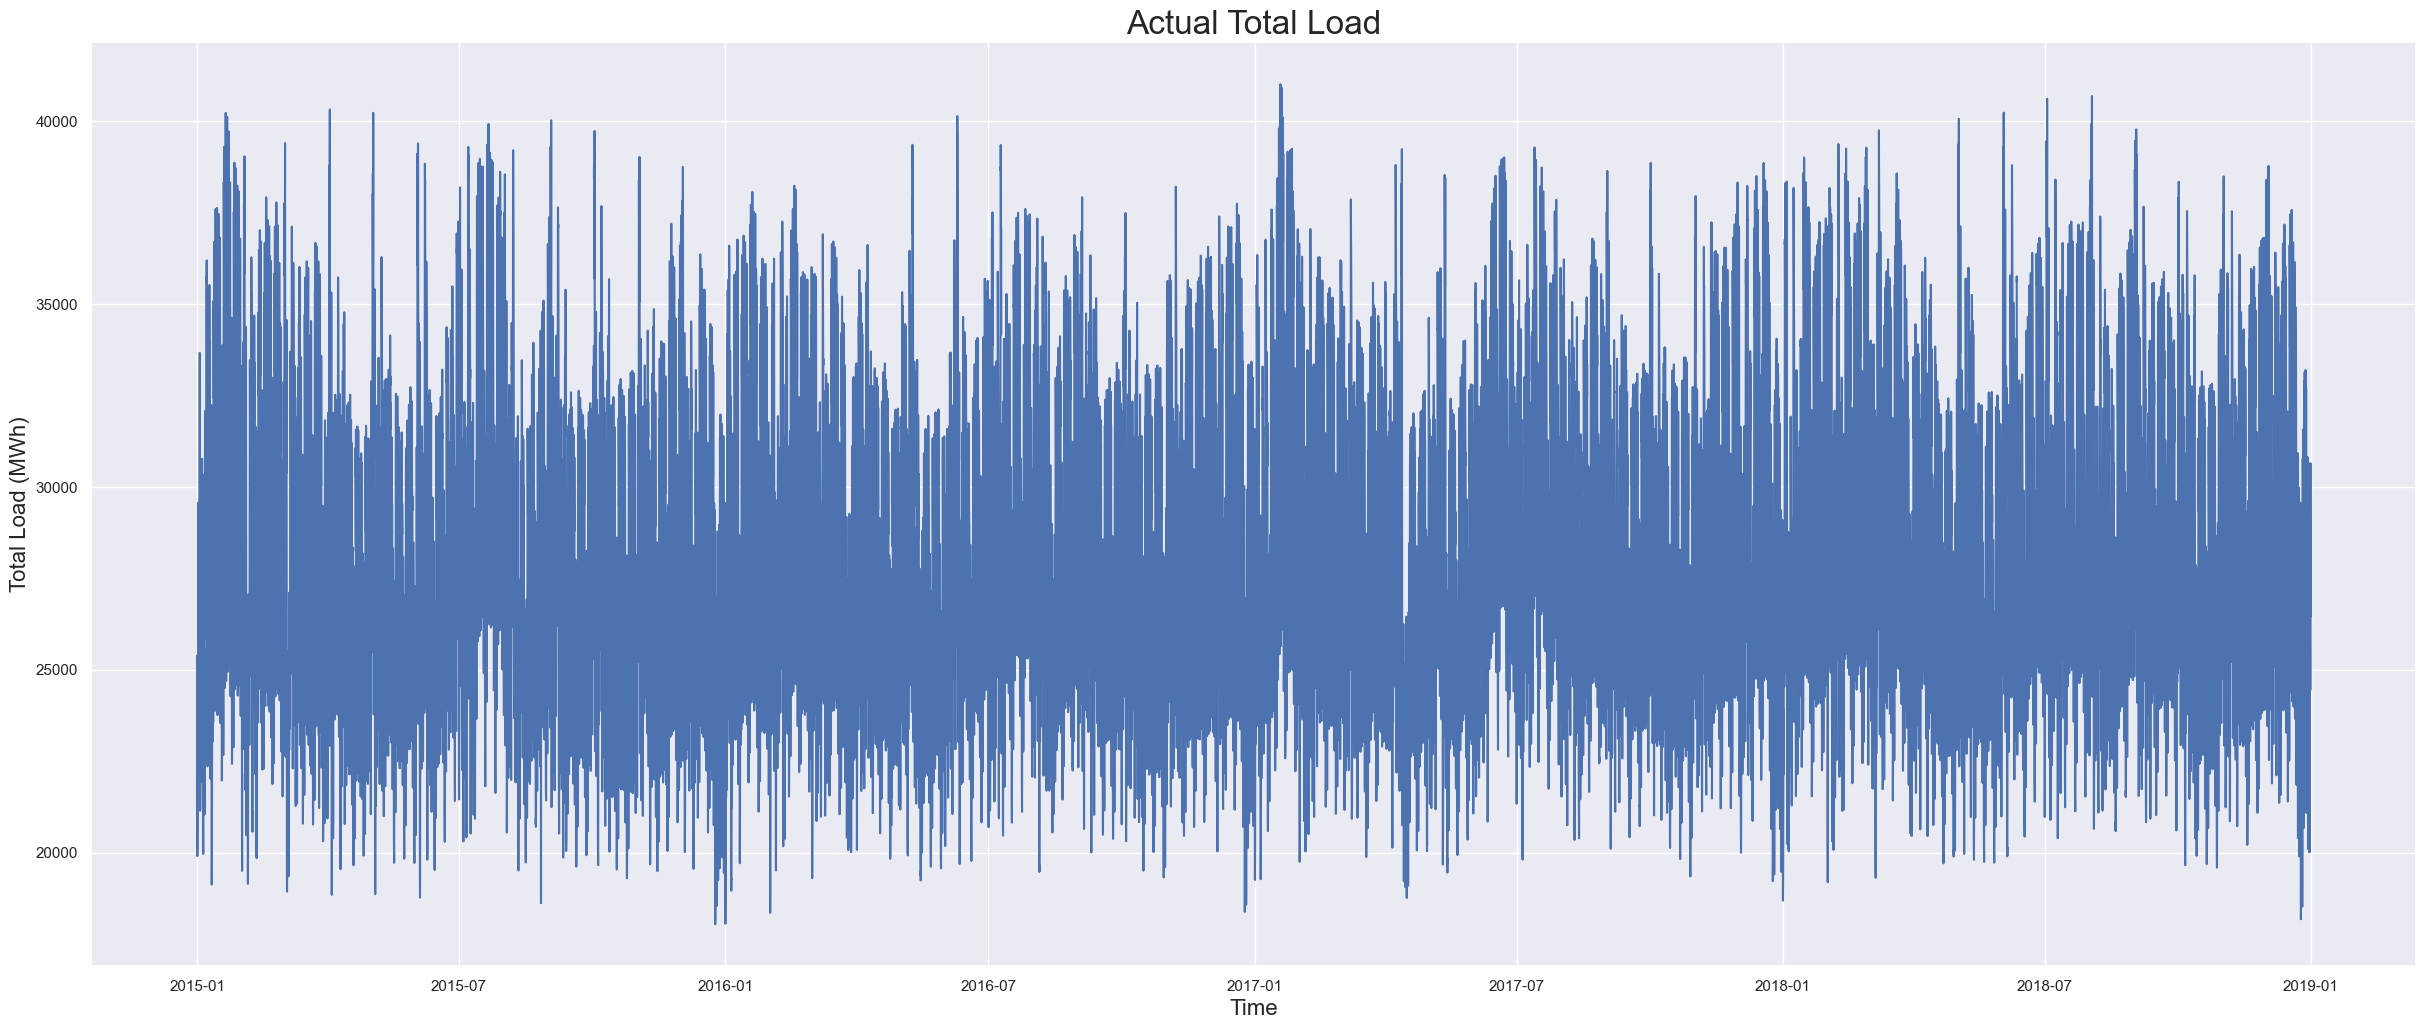

In [10]:
# Zoom into the plot of the hourly (actual) total load

ax = plot_series(df=df_energy, column='total load actual', ylabel='Total Load (MWh)',
                 title='Actual Total Load')
plt.show()

In [11]:
# Find missing value
print('There are {} missing values or NaNs in df_energy.'
      .format(df_energy.isnull().values.sum()))

There are 292 missing values or NaNs in df_energy.


In [12]:
# Find the number of NaNs in each column

df_energy.isnull().sum(axis=0)

generation biomass                             19
generation fossil brown coal/lignite           18
generation fossil gas                          18
generation fossil hard coal                    18
generation fossil oil                          19
generation hydro pumped storage consumption    19
generation hydro run-of-river and poundage     19
generation hydro water reservoir               18
generation nuclear                             17
generation other                               18
generation other renewable                     18
generation solar                               18
generation waste                               19
generation wind onshore                        18
total load actual                              36
price day ahead                                 0
price actual                                    0
dtype: int64

In [13]:
# Display the rows with null values
df_energy[df_energy.isnull().any(axis=1)]

generation biomass  \
time                                            
2015-01-05 02:00:00+00:00                 NaN   
2015-01-05 11:00:00+00:00                 NaN   
2015-01-05 12:00:00+00:00                 NaN   
2015-01-05 13:00:00+00:00                 NaN   
2015-01-05 14:00:00+00:00                 NaN   
2015-01-05 15:00:00+00:00                 NaN   
2015-01-05 16:00:00+00:00                 NaN   
2015-01-19 18:00:00+00:00                 NaN   
2015-01-19 19:00:00+00:00                 NaN   
2015-01-27 18:00:00+00:00                 NaN   
2015-01-28 12:00:00+00:00                 NaN   
2015-02-01 06:00:00+00:00               449.0   
2015-02-01 07:00:00+00:00               453.0   
2015-02-01 08:00:00+00:00               452.0   
2015-02-01 11:00:00+00:00               405.0   
2015-02-01 12:00:00+00:00               402.0   
2015-02-01 13:00:00+00:00               400.0   
2015-02-01 14:00:00+00:00               393.0   
2015-02-01 15:00:00+00:00               413.0   
2015-02-01 16:00:00+00:00               465.0   
2015-02-01 17:00:00+00:00               482.0   
2015-02-01 18:00:00+00:00               474.0   
2015-04-05 01:00:00+00:00               371.0   
2015-04-16 07:00:00+00:00                 NaN   
2015-04-20 06:00:00+00:00               424.0   
2015-04-23 19:00:00+00:00                 NaN   
2015-05-02 08:00:00+00:00               497.0   
2015-05-29 01:00:00+00:00               569.0   
2015-06-15 07:00:00+00:00                 NaN   
2015-10-02 06:00:00+00:00               483.0   
2015-10-02 09:00:00+00:00                 NaN   
2015-12-02 08:00:00+00:00                 NaN   
2016-04-13 03:00:00+00:00               220.0   
2016-04-25 03:00:00+00:00               190.0   
2016-04-25 05:00:00+00:00               206.0   
2016-05-10 21:00:00+00:00               348.0   
2016-06-11 23:00:00+00:00               356.0   
2016-07-09 20:00:00+00:00                 NaN   
2016-07-11 22:00:00+00:00               346.0   
2016-09-28 07:00:00+00:00               347.0   
2016-10-27 21:00:00+00:00               351.0   
2016-11-23 03:00:00+00:00                 NaN   
2017-11-14 11:00:00+00:00                 0.0   
2017-11-14 18:00:00+00:00                 0.0   
2018-06-11 16:00:00+00:00               331.0   
2018-07-11 07:00:00+00:00                 NaN   

                           generation fossil brown coal/lignite  \
time                                                              
2015-01-05 02:00:00+00:00                                   NaN   
2015-01-05 11:00:00+00:00                                   NaN   
2015-01-05 12:00:00+00:00                                   NaN   
2015-01-05 13:00:00+00:00                                   NaN   
2015-01-05 14:00:00+00:00                                   NaN   
2015-01-05 15:00:00+00:00                                   NaN   
2015-01-05 16:00:00+00:00                                   NaN   
2015-01-19 18:00:00+00:00                                   NaN   
2015-01-19 19:00:00+00:00                                   NaN   
2015-01-27 18:00:00+00:00                                   NaN   
2015-01-28 12:00:00+00:00                                   NaN   
2015-02-01 06:00:00+00:00                                 312.0   
2015-02-01 07:00:00+00:00                                 312.0   
2015-02-01 08:00:00+00:00                                 302.0   
2015-02-01 11:00:00+00:00                                 317.0   
2015-02-01 12:00:00+00:00                                 317.0   
2015-02-01 13:00:00+00:00                                 317.0   
2015-02-01 14:00:00+00:00                                 321.0   
2015-02-01 15:00:00+00:00                                 325.0   
2015-02-01 16:00:00+00:00                                 321.0   
2015-02-01 17:00:00+00:00                                 326.0   
2015-02-01 18:00:00+00:00                                 326.0   
2015-04-05 01:00:00+00:00                                   0.0   

In [14]:
# Fill null values using interpolation
df_energy.interpolate(method='linear', limit_direction='forward', inplace=True, axis=0)

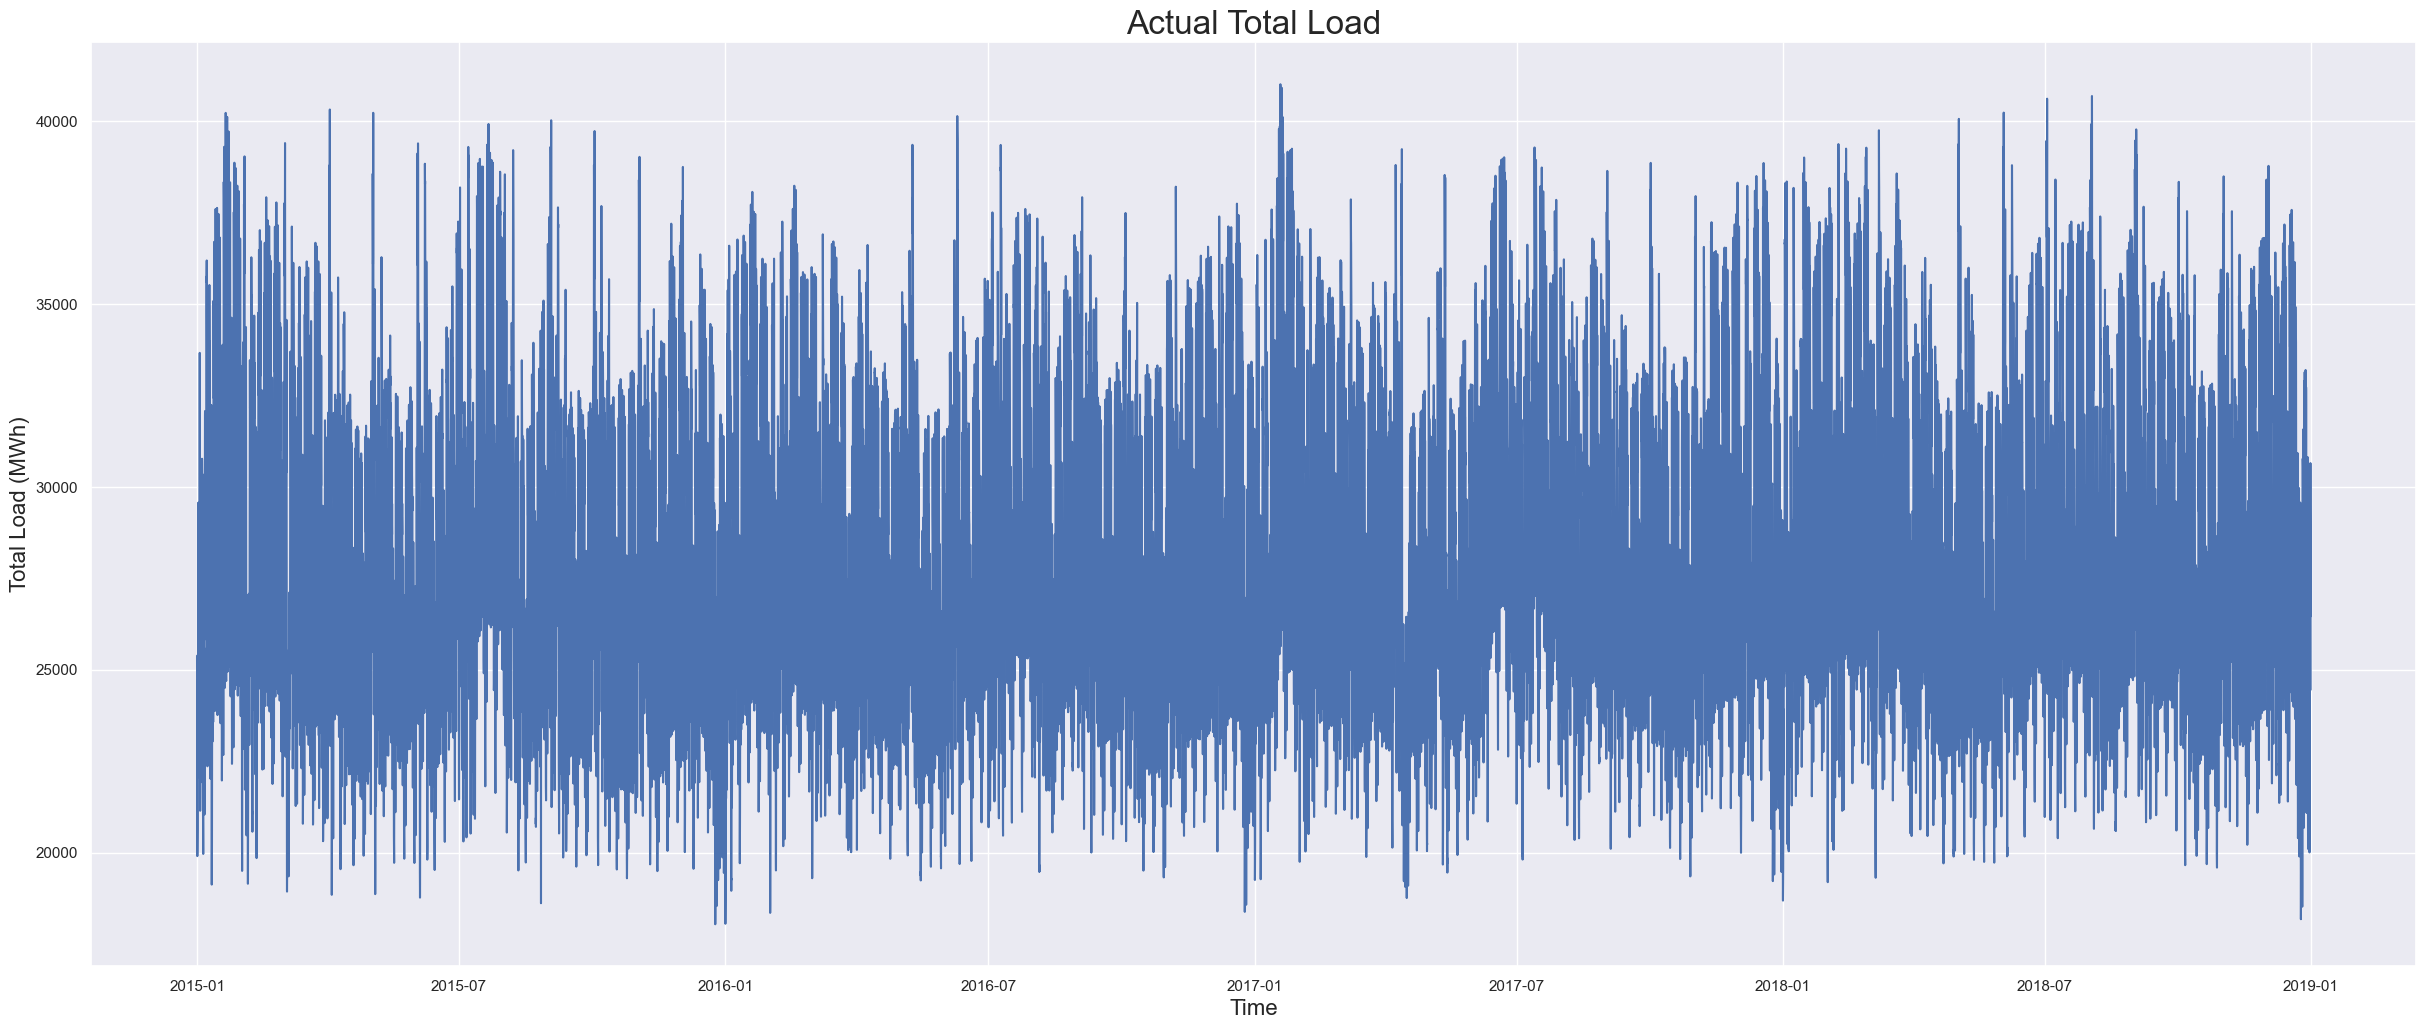

In [15]:
# PLot after missing value handling

ax = plot_series(df=df_energy, column='total load actual', ylabel='Total Load (MWh)',
                 title='Actual Total Load')
plt.show()

In [16]:
df_energy

generation biomass  \
time                                            
2014-12-31 23:00:00+00:00               447.0   
2015-01-01 00:00:00+00:00               449.0   
2015-01-01 01:00:00+00:00               448.0   
2015-01-01 02:00:00+00:00               438.0   
2015-01-01 03:00:00+00:00               428.0   
...                                       ...   
2018-12-31 18:00:00+00:00               297.0   
2018-12-31 19:00:00+00:00               296.0   
2018-12-31 20:00:00+00:00               292.0   
2018-12-31 21:00:00+00:00               293.0   
2018-12-31 22:00:00+00:00               290.0   

                           generation fossil brown coal/lignite  \
time                                                              
2014-12-31 23:00:00+00:00                                 329.0   
2015-01-01 00:00:00+00:00                                 328.0   
2015-01-01 01:00:00+00:00                                 323.0   
2015-01-01 02:00:00+00:00                                 254.0   
2015-01-01 03:00:00+00:00                                 187.0   
...                                                         ...   
2018-12-31 18:00:00+00:00                                   0.0   
2018-12-31 19:00:00+00:00                                   0.0   
2018-12-31 20:00:00+00:00                                   0.0   
2018-12-31 21:00:00+00:00                                   0.0   
2018-12-31 22:00:00+00:00                                   0.0   

                           generation fossil gas  generation fossil hard coal  \
time                                                                            
2014-12-31 23:00:00+00:00                 4844.0                       4821.0   
2015-01-01 00:00:00+00:00                 5196.0                       4755.0   
2015-01-01 01:00:00+00:00                 4857.0                       4581.0   
2015-01-01 02:00:00+00:00                 4314.0                       4131.0   
2015-01-01 03:00:00+00:00                 4130.0                       3840.0   
...                                          ...                          ...   
2018-12-31 18:00:00+00:00                 7634.0                       2628.0   
2018-12-31 19:00:00+00:00                 7241.0                       2566.0   
2018-12-31 20:00:00+00:00                 7025.0                       2422.0   
2018-12-31 21:00:00+00:00                 6562.0                       2293.0   
2018-12-31 22:00:00+00:00                 6926.0                       2166.0   

                           generation fossil oil  \
time                                               
2014-12-31 23:00:00+00:00                  162.0   
2015-01-01 00:00:00+00:00                  158.0   
2015-01-01 01:00:00+00:00                  157.0   
2015-01-01 02:00:00+00:00                  160.0   
2015-01-01 03:00:00+00:00                  156.0   
...                                          ...   
2018-12-31 18:00:00+00:00                  178.0   
2018-12-31 19:00:00+00:00                  174.0   
2018-12-31 20:00:00+00:00                  168.0   
2018-12-31 21:00:00+00:00                  163.0   
2018-12-31 22:00:00+00:00                  163.0   

                           generation hydro pumped storage consumption  \
time                                                                     
2014-12-31 23:00:00+00:00                                        863.0   
2015-01-01 00:00:00+00:00                                        920.0   
2015-01-01 01:00:00+00:00                                       1164.0   
2015-01-01 02:00:00+00:00                                       1503.0   
2015-01-01 03:00:00+00:00                                       1826.0   
...                                                                ...   
2018-12-31 18:00:00+00:00                                          1.0   
2018-12-31 19:00:00+00:00                                          1.0   
2018-12-31 20:00:00+00:00                     

# Weather Dataset

In [17]:
df_weather = pd.read_csv(
    'D:\dibimbing.id\CapstoneProject\energy_price\weather_features.csv', 
    parse_dates=['dt_iso']
)

In [18]:
df_weather.head()

dt_iso city_name     temp  temp_min  temp_max  pressure  \
0  2015-01-01 00:00:00+01:00  Valencia  270.475   270.475   270.475      1001   
1  2015-01-01 01:00:00+01:00  Valencia  270.475   270.475   270.475      1001   
2  2015-01-01 02:00:00+01:00  Valencia  269.686   269.686   269.686      1002   
3  2015-01-01 03:00:00+01:00  Valencia  269.686   269.686   269.686      1002   
4  2015-01-01 04:00:00+01:00  Valencia  269.686   269.686   269.686      1002   

   humidity  wind_speed  wind_deg  rain_1h  rain_3h  snow_3h  clouds_all  \
0        77           1        62      0.0      0.0      0.0           0   
1        77           1        62      0.0      0.0      0.0           0   
2        78           0        23      0.0      0.0      0.0           0   
3        78           0        23      0.0      0.0      0.0           0   
4        78           0        23      0.0      0.0      0.0           0   

   weather_id weather_main weather_description weather_icon  
0         800        clear        sky is clear          01n  
1         800        clear        sky is clear          01n  
2         800        clear        sky is clear          01n  
3         800        clear        sky is clear          01n  
4         800        clear        sky is clear          01n

In [19]:
df_weather.tail(10)

dt_iso city_name    temp  temp_min  temp_max  \
178386  2018-12-31 14:00:00+01:00   Seville  289.15    289.15    289.15   
178387  2018-12-31 15:00:00+01:00   Seville  290.15    290.15    290.15   
178388  2018-12-31 16:00:00+01:00   Seville  291.15    291.15    291.15   
178389  2018-12-31 17:00:00+01:00   Seville  291.15    291.15    291.15   
178390  2018-12-31 18:00:00+01:00   Seville  291.38    290.15    292.15   
178391  2018-12-31 19:00:00+01:00   Seville  287.76    287.15    288.15   
178392  2018-12-31 20:00:00+01:00   Seville  285.76    285.15    286.15   
178393  2018-12-31 21:00:00+01:00   Seville  285.15    285.15    285.15   
178394  2018-12-31 22:00:00+01:00   Seville  284.15    284.15    284.15   
178395  2018-12-31 23:00:00+01:00   Seville  283.97    282.15    285.15   

        pressure  humidity  wind_speed  wind_deg  rain_1h  rain_3h  snow_3h  \
178386      1029        59           5        60      0.0      0.0      0.0   
178387      1028        51           5        40      0.0      0.0      0.0   
178388      1028        48           5        50      0.0      0.0      0.0   
178389      1028        42           4        50      0.0      0.0      0.0   
178390      1028        42           4        60      0.0      0.0      0.0   
178391      1028        54           3        30      0.0      0.0      0.0   
178392      1029        62           3        30      0.0      0.0      0.0   
178393      1028        58           4        50      0.0      0.0      0.0   
178394      1029        57           4        60      0.0      0.0      0.0   
178395      1029        70           3        50      0.0      0.0      0.0   

        clouds_all  weather_id weather_main weather_description weather_icon  
178386           0         800        clear        sky is clear          01d  
178387           0         800        clear        sky is clear          01d  
178388           0         800        clear        sky is clear          01d  
178389           0         800        clear        sky is clear          01d  
178390           0         800        clear        sky is clear          01d  
178391           0         800        clear        sky is clear          01n  
178392           0         800        clear        sky is clear          01n  
178393           0         800        clear        sky is clear          01n  
178394           0         800        clear        sky is clear          01n  
178395           0         800        clear        sky is clear          01n

In [20]:
df_weather.describe()

temp       temp_min       temp_max      pressure  \
count  178396.000000  178396.000000  178396.000000  1.783960e+05   
mean      289.618605     288.330442     291.091267  1.069261e+03   
std         8.026199       7.955491       8.612454  5.969632e+03   
min       262.240000     262.240000     262.240000  0.000000e+00   
25%       283.670000     282.483602     284.650000  1.013000e+03   
50%       289.150000     288.150000     290.150000  1.018000e+03   
75%       295.150000     293.730125     297.150000  1.022000e+03   
max       315.600000     315.150000     321.150000  1.008371e+06   

            humidity    wind_speed       wind_deg        rain_1h  \
count  178396.000000  178396.00000  178396.000000  178396.000000   
mean       68.423457       2.47056     166.591190       0.075492   
std        21.902888       2.09591     116.611927       0.398847   
min         0.000000       0.00000       0.000000       0.000000   
25%        53.000000       1.00000      55.000000       0.000000   
50%        72.000000       2.00000     177.000000       0.000000   
75%        87.000000       4.00000     270.000000       0.000000   
max       100.000000     133.00000     360.000000      12.000000   

             rain_3h        snow_3h     clouds_all     weather_id  
count  178396.000000  178396.000000  178396.000000  178396.000000  
mean        0.000380       0.004763      25.073292     759.831902  
std         0.007288       0.222604      30.774129     108.733223  
min         0.000000       0.000000       0.000000     200.000000  
25%         0.000000       0.000000       0.000000     800.000000  
50%         0.000000       0.000000      20.000000     800.000000  
75%         0.000000       0.000000      40.000000     801.000000  
max         2.315000      21.500000     100.000000     804.000000

In [21]:
df_weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 178396 entries, 0 to 178395
Data columns (total 17 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   dt_iso               178396 non-null  object 
 1   city_name            178396 non-null  object 
 2   temp                 178396 non-null  float64
 3   temp_min             178396 non-null  float64
 4   temp_max             178396 non-null  float64
 5   pressure             178396 non-null  int64  
 6   humidity             178396 non-null  int64  
 7   wind_speed           178396 non-null  int64  
 8   wind_deg             178396 non-null  int64  
 9   rain_1h              178396 non-null  float64
 10  rain_3h              178396 non-null  float64
 11  snow_3h              178396 non-null  float64
 12  clouds_all           178396 non-null  int64  
 13  weather_id           178396 non-null  int64  
 14  weather_main         178396 non-null  object 
 15  weather_descripti

In [22]:
def df_convert_dtypes(df, convert_from, convert_to):
    cols = df.select_dtypes(include=[convert_from]).columns
    for col in cols:
        df[col] = df[col].values.astype(convert_to)
    return df

# Convert columns with int64 type values to float64 type
df_weather = df_convert_dtypes(df_weather, np.int64, np.float64)

In [23]:
# Convert dt_iso to datetime type, rename it and set it as index
df_weather['time'] = pd.to_datetime(df_weather['dt_iso'], utc=True, infer_datetime_format=True)
df_weather = df_weather.drop(['dt_iso'], axis=1)
df_weather = df_weather.set_index('time')

In [24]:
# Display average weather features grouped by each city
mean_weather_by_city = df_weather.groupby('city_name')
mean_weather_by_city

In [25]:
# Find NaNs and duplicates in df_weather

print('There are {} missing values or NaNs in df_weather.'
      .format(df_weather.isnull().values.sum()))

temp_weather = df_weather.duplicated(keep='first').sum()

print('There are {} duplicate rows in df_weather based on all columns.'
      .format(temp_weather))

There are 0 missing values or NaNs in df_weather.
There are 8622 duplicate rows in df_weather based on all columns.


In [26]:
# Display the number of rows in each dataframe

print('There are {} observations in df_energy.'.format(df_energy.shape[0]))

cities = df_weather['city_name'].unique()
grouped_weather = df_weather.groupby('city_name')

for city in cities:
    print('There are {} observations in df_weather'
          .format(grouped_weather.get_group('{}'.format(city)).shape[0]), 
          'about city: {}.'.format(city))

There are 35064 observations in df_energy.
There are 35145 observations in df_weather about city: Valencia.
There are 36267 observations in df_weather about city: Madrid.
There are 35951 observations in df_weather about city: Bilbao.
There are 35476 observations in df_weather about city:  Barcelona.
There are 35557 observations in df_weather about city: Seville.


In [28]:
# Create df_weather_2 and drop duplicate rows in df_weather

df_weather_2 = df_weather.reset_index().drop_duplicates(subset=['time', 'city_name'], 
                                                        keep='last').set_index('time')

df_weather = df_weather.reset_index().drop_duplicates(subset=['time', 'city_name'],
                                                      keep='first').set_index('time')

In [29]:
# Display the number of rows in each dataframe again

print('There are {} observations in df_energy.'.format(df_energy.shape[0]))

grouped_weather = df_weather.groupby('city_name')

for city in cities:
    print('There are {} observations in df_weather'
          .format(grouped_weather.get_group('{}'.format(city)).shape[0]), 
          'about city: {}.'.format(city))

There are 35064 observations in df_energy.
There are 35064 observations in df_weather about city: Valencia.
There are 35064 observations in df_weather about city: Madrid.
There are 35064 observations in df_weather about city: Bilbao.
There are 35064 observations in df_weather about city:  Barcelona.
There are 35064 observations in df_weather about city: Seville.


In [30]:
# Display all the unique values in the column 'weather_description'

weather_description_unique = df_weather['weather_description'].unique()
weather_description_unique

array(['sky is clear', 'few clouds', 'scattered clouds', 'broken clouds',
       'overcast clouds', 'light rain', 'moderate rain',
       'heavy intensity rain', 'mist', 'heavy intensity shower rain',
       'shower rain', 'very heavy rain', 'thunderstorm with heavy rain',
       'thunderstorm with light rain', 'proximity thunderstorm',
       'thunderstorm', 'light intensity shower rain',
       'light intensity drizzle', 'thunderstorm with rain', 'fog',
       'smoke', 'drizzle', 'heavy intensity drizzle', 'haze',
       'proximity shower rain', 'light snow', 'rain and snow',
       'light rain and snow', 'snow', 'sleet', 'rain and drizzle',
       'light intensity drizzle rain', 'light shower snow',
       'proximity moderate rain', 'ragged shower rain', 'heavy snow',
       'sand dust whirls', 'proximity drizzle', 'dust',
       'light thunderstorm', 'squalls'], dtype=object)

In [31]:
#Display all the unique values in the column 'weather_main'

weather_main_unique = df_weather['weather_main'].unique()
weather_main_unique

array(['clear', 'clouds', 'rain', 'mist', 'thunderstorm', 'drizzle',
       'fog', 'smoke', 'haze', 'snow', 'dust', 'squall'], dtype=object)

In [32]:
# Define a function which will calculate R-squared score for the same column in two dataframes

def encode_and_display_r2_score(df_1, df_2, column, categorical=False):
    dfs = [df_1, df_2]
    if categorical:
        for df in dfs:
            le = LabelEncoder()
            df[column] = le.fit_transform(df[column])
    r2 = r2_score(df_1[column], df_2[column])
    print("R-Squared score of {} is {}".format(column, r2.round(3)))

In [33]:
# Display the R-squared scores for the columns with qualitative weather descriptions in df_weather and df_weather_2

encode_and_display_r2_score(df_weather, df_weather_2, 'weather_description', categorical=True)
encode_and_display_r2_score(df_weather, df_weather_2, 'weather_main', categorical=True)
encode_and_display_r2_score(df_weather, df_weather_2, 'weather_id')

R-Squared score of weather_description is 0.973
R-Squared score of weather_main is 0.963
R-Squared score of weather_id is 0.921


In [34]:
# Drop columns with qualitative weather information
df_weather = df_weather.drop(['weather_main', 'weather_id', 
                              'weather_description', 'weather_icon'], axis=1)

In [35]:
# Display the R-squared for all the columns in df_weather and df_weather_2
df_weather_cols = df_weather.columns.drop('city_name')

for col in df_weather_cols:
    encode_and_display_r2_score(df_weather, df_weather_2, col)

R-Squared score of temp is 1.0
R-Squared score of temp_min is 1.0
R-Squared score of temp_max is 1.0
R-Squared score of pressure is 1.0
R-Squared score of humidity is 1.0
R-Squared score of wind_speed is 1.0
R-Squared score of wind_deg is 1.0
R-Squared score of rain_1h is 1.0
R-Squared score of rain_3h is 1.0
R-Squared score of snow_3h is 1.0
R-Squared score of clouds_all is 1.0


In [36]:
# Display the number of duplicates in df_weather

temp_weather = df_weather.reset_index().duplicated(subset=['time', 'city_name'], 
                                                   keep='first').sum()
print('There are {} duplicate rows in df_weather ' \
      'based on all columns except "time" and "city_name".'.format(temp_weather))

There are 0 duplicate rows in df_weather based on all columns except "time" and "city_name".


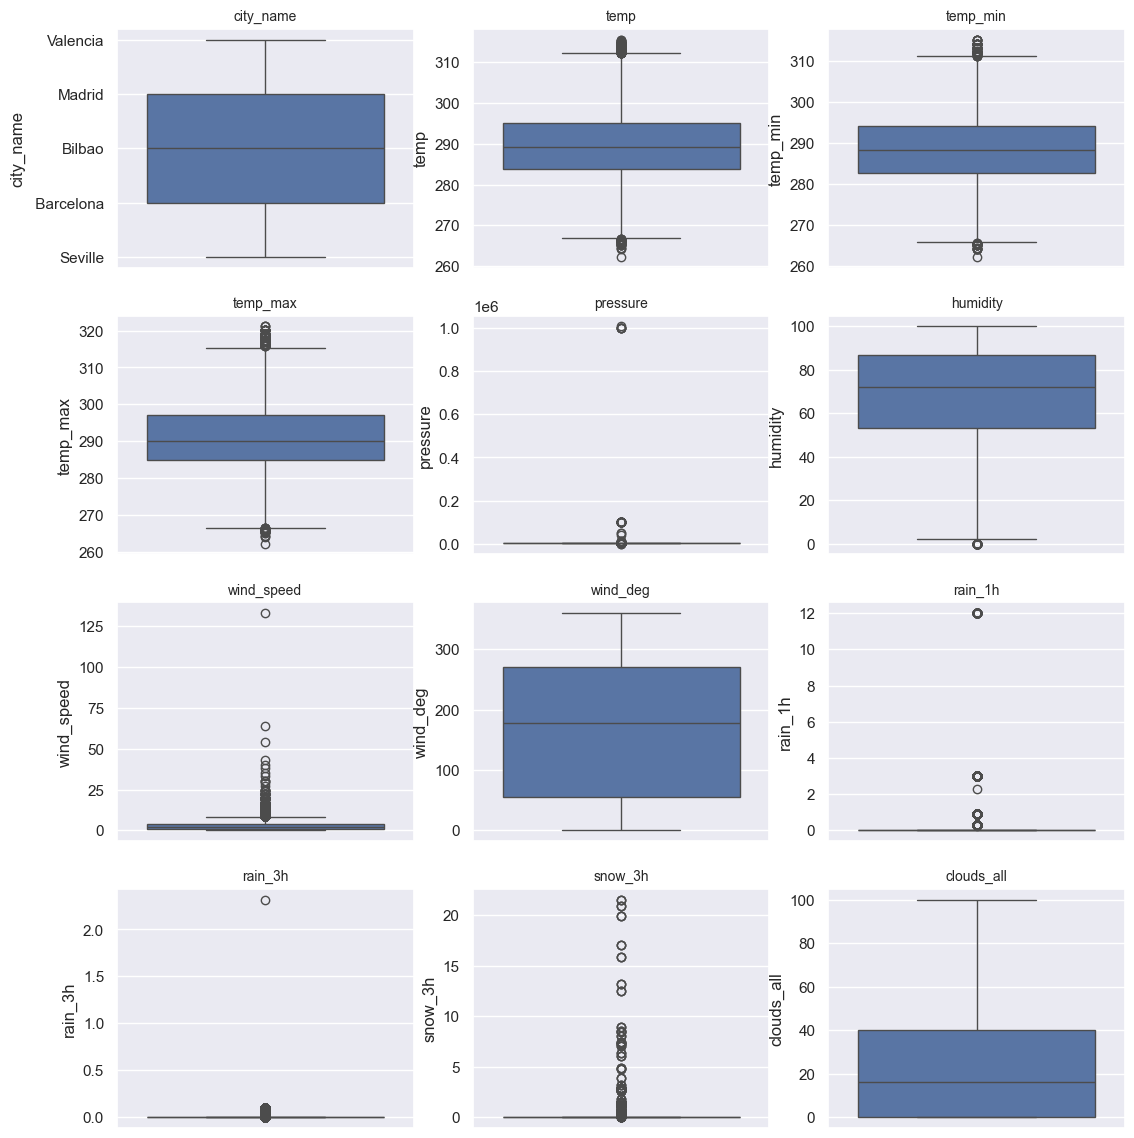

In [37]:
# Membuat visualisasi boxplot per kolom
plt.figure(figsize=(13, 18))

for idx, column in enumerate(df_weather.columns, 1): # enumerate() mengiterasi objek dan indeksnya
    plt.subplot(5, 3, idx)
    sns.boxplot(df_weather[column])
    plt.title(column, fontsize=10)

plt.show()

In [39]:
# Create list column will be transformed
cols_to_transform = ['temp', 'temp_min', 'temp_max', 'pressure',
                     'wind_speed', 'rain_1h', 'rain_3h', 'snow_3h']

# Lakukan iterasi atas log transform pada setiap kolom
for col in cols_to_transform:
  df_weather[col] = np.log1p(df_weather[col])

In [40]:
# Fill null values using interpolation

df_weather.interpolate(method='linear', limit_direction='forward', inplace=True, axis=0)

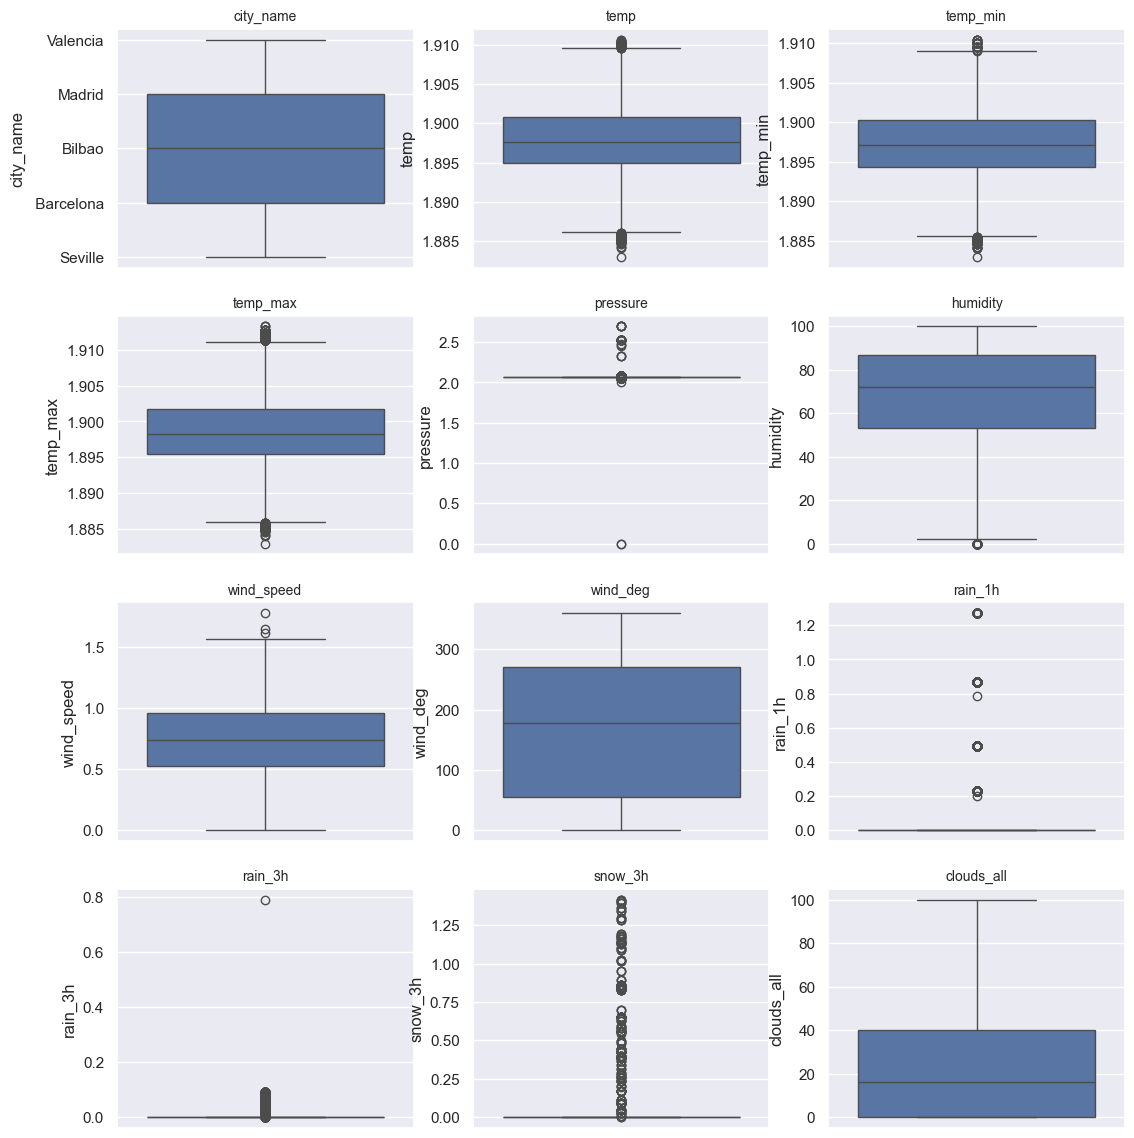

In [41]:
# Recheck
plt.figure(figsize=(13, 18))

for idx, column in enumerate(df_weather.columns, 1): 
    plt.subplot(5, 3, idx)
    sns.boxplot(df_weather[column])
    plt.title(column, fontsize=10)

plt.show()

In [42]:
# Split the df_weather into 5 dataframes (one for each city)

df_valencia, df_madrid, df_bilbao, df_barcelona, df_seville = [x for _, x in df_weather.groupby('city_name')]
dfs = [df_valencia, df_madrid, df_bilbao, df_barcelona, df_seville]

In [43]:
# Merge all dataframes into the final dataframe

df_final = df_energy

for df in dfs:
    city = df['city_name'].unique()
    city_str = str(city).replace("'", "").replace('[', '').replace(']', '').replace(' ', '')
    df = df.add_suffix('_{}'.format(city_str))
    df_final = df_final.merge(df, on=['time'], how='outer')
    df_final = df_final.drop('city_name_{}'.format(city_str), axis=1)
    
df_final.columns

Index(['generation biomass', 'generation fossil brown coal/lignite',
       'generation fossil gas', 'generation fossil hard coal',
       'generation fossil oil', 'generation hydro pumped storage consumption',
       'generation hydro run-of-river and poundage',
       'generation hydro water reservoir', 'generation nuclear',
       'generation other', 'generation other renewable', 'generation solar',
       'generation waste', 'generation wind onshore', 'total load actual',
       'price day ahead', 'price actual', 'temp_Barcelona',
       'temp_min_Barcelona', 'temp_max_Barcelona', 'pressure_Barcelona',
       'humidity_Barcelona', 'wind_speed_Barcelona', 'wind_deg_Barcelona',
       'rain_1h_Barcelona', 'rain_3h_Barcelona', 'snow_3h_Barcelona',
       'clouds_all_Barcelona', 'temp_Bilbao', 'temp_min_Bilbao',
       'temp_max_Bilbao', 'pressure_Bilbao', 'humidity_Bilbao',
       'wind_speed_Bilbao', 'wind_deg_Bilbao', 'rain_1h_Bilbao',
       'rain_3h_Bilbao', 'snow_3h_Bilbao', 'clo

In [44]:
# Display the number of NaNs and duplicates in the final dataframe

print('There are {} missing values or NaNs in df_final.'
      .format(df_final.isnull().values.sum()))

temp_final = df_final.duplicated(keep='first').sum()

print('\nThere are {} duplicate rows in df_energy based on all columns.'
      .format(temp_final))

There are 0 missing values or NaNs in df_final.

There are 0 duplicate rows in df_energy based on all columns.


# Visualization

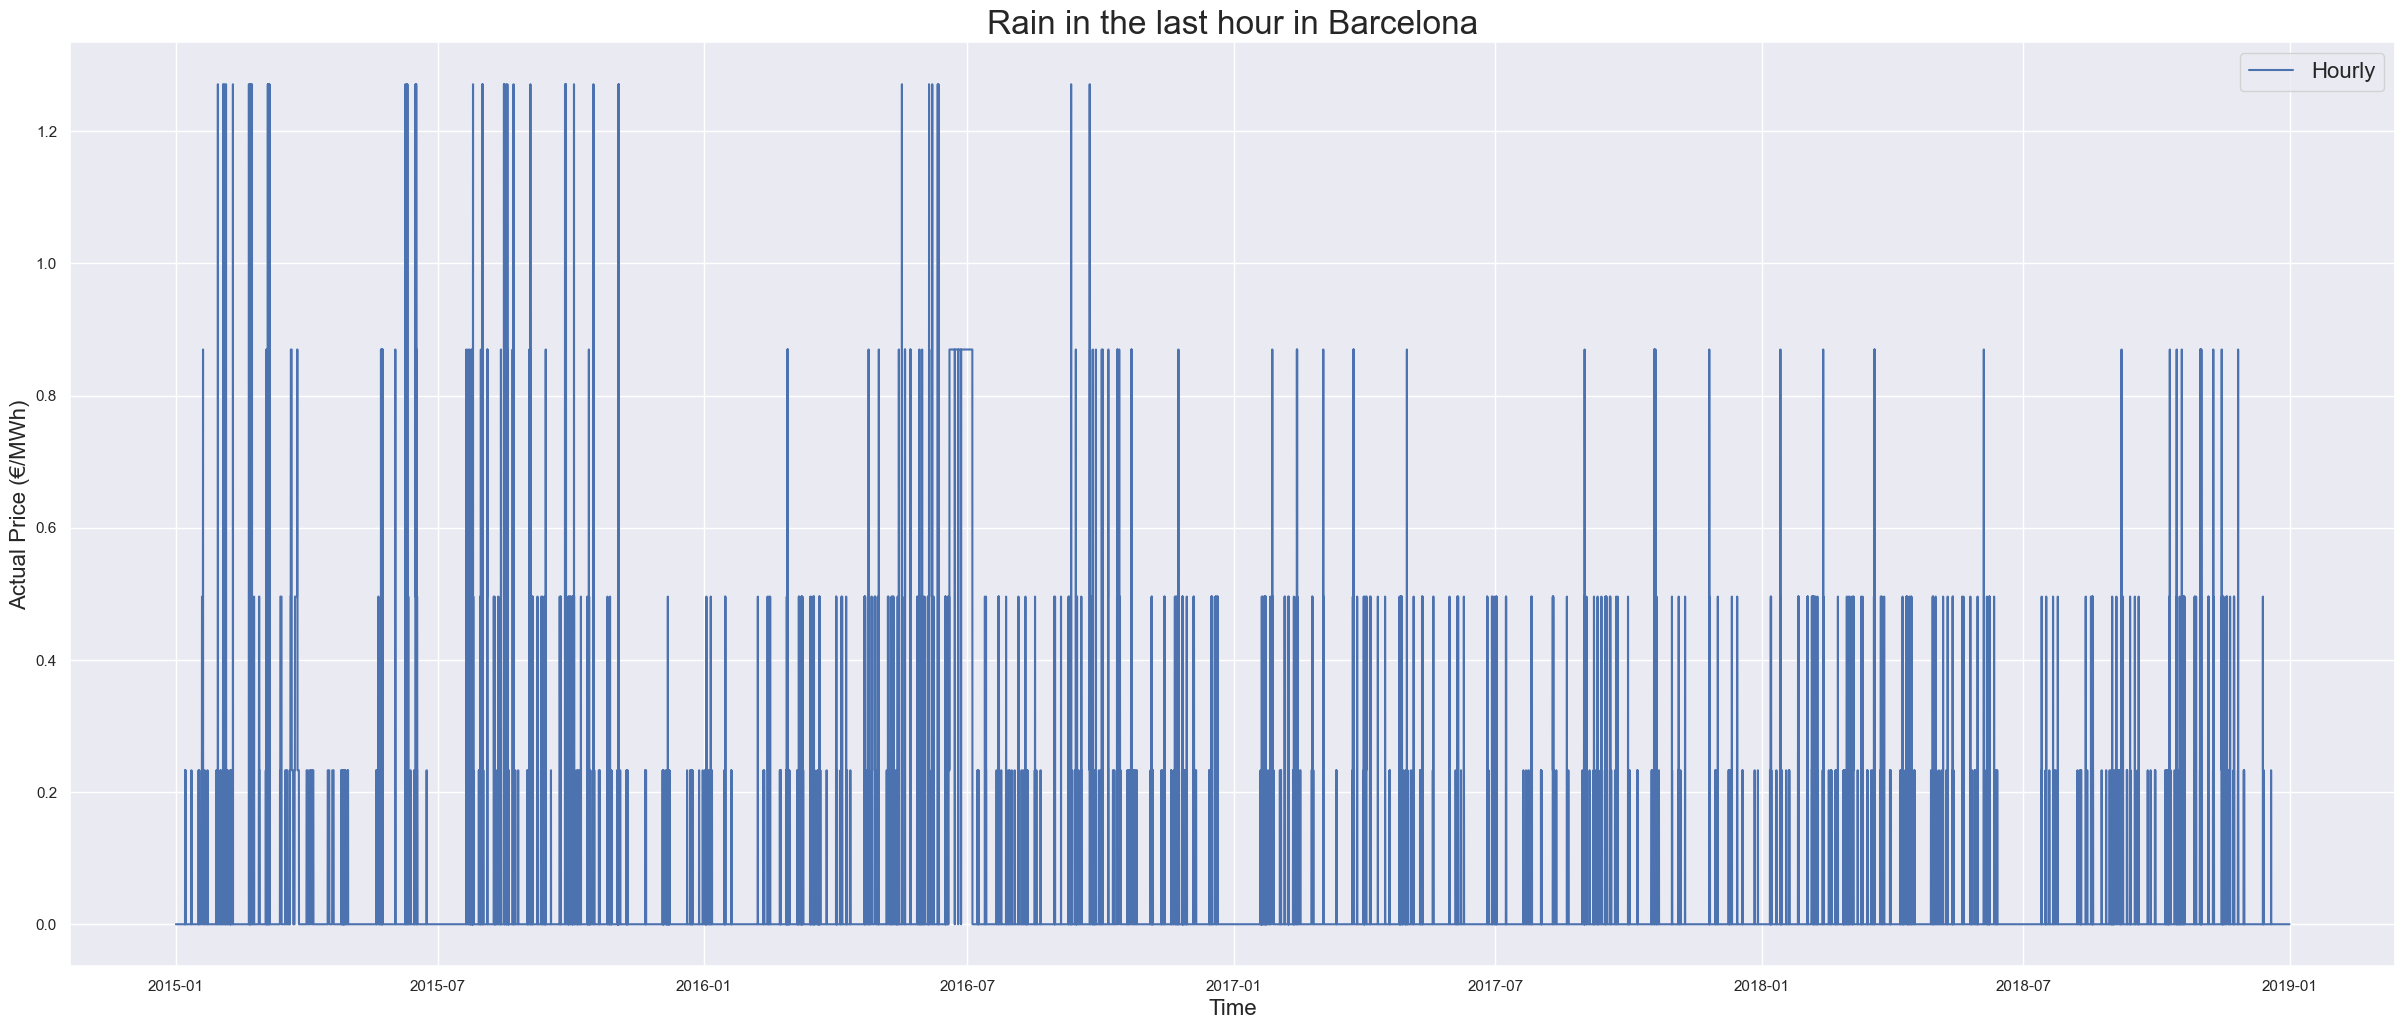

In [45]:
# Plot the 'rain_1h' for Barcelona

ax = plot_series(df_final, 'rain_1h_Barcelona', 
                 label='Hourly', ylabel='Actual Price (€/MWh)',
                 title='Rain in the last hour in Barcelona')
plt.show()

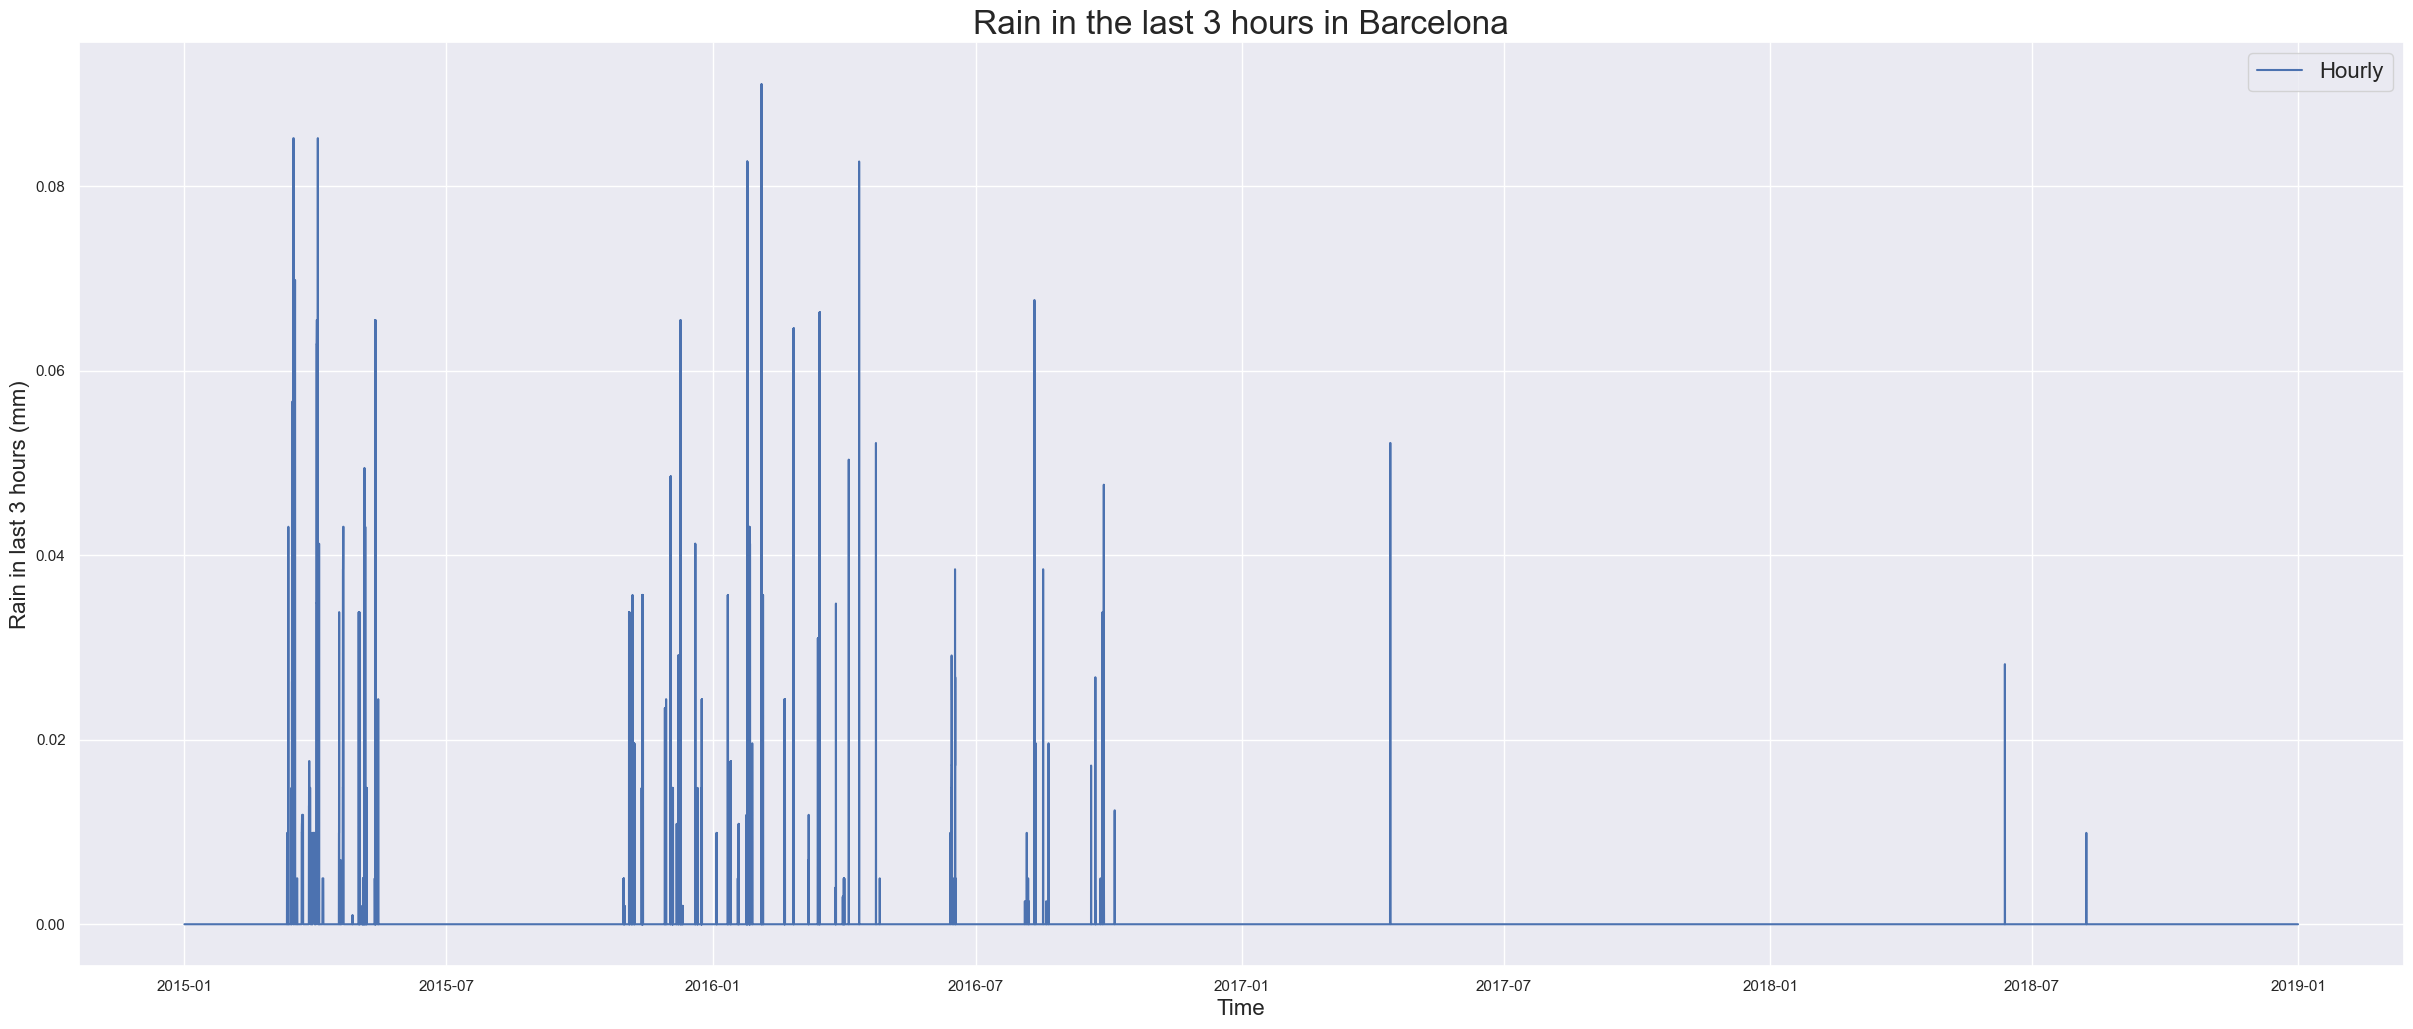

In [46]:
# Plot the 'rain_3h' for Barcelona

ax = plot_series(df_final, 'rain_3h_Barcelona', 
                 label='Hourly', ylabel='Rain in last 3 hours (mm)',
                 title='Rain in the last 3 hours in Barcelona')
plt.show()

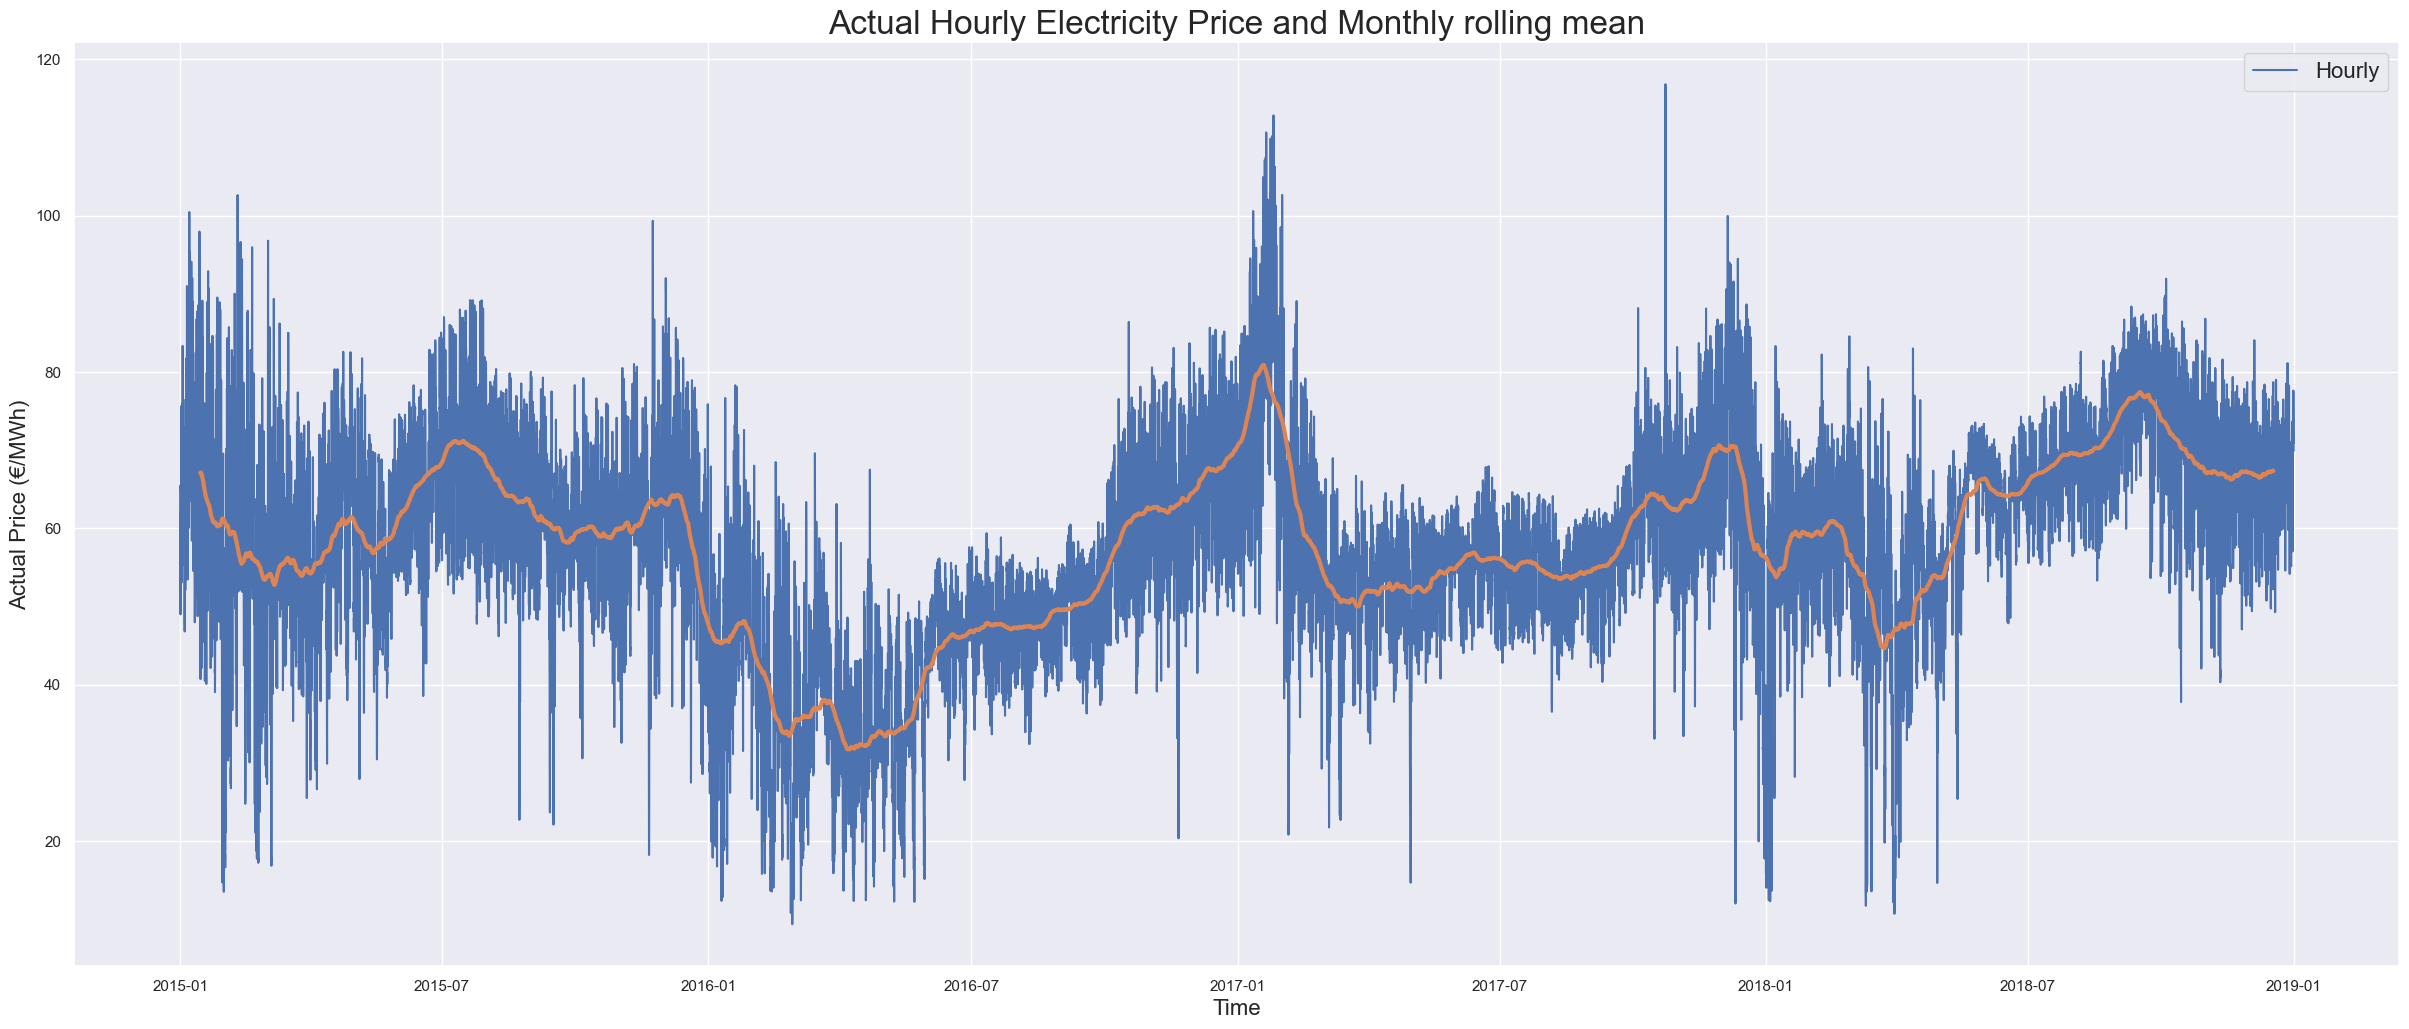

In [47]:
# Plot the hourly actual electricity price, along with the monthly rolling mean

rolling = df_final['price actual'].rolling(24*7*4, center=True).mean()
ax = plot_series(df_final, 'price actual', label='Hourly', ylabel='Actual Price (€/MWh)',
                 title='Actual Hourly Electricity Price and Monthly rolling mean')
ax.plot(rolling, linestyle='-', linewidth=3, label='Monthly rolling mean')
plt.show()

Text(0.5, 1.0, 'price actual')

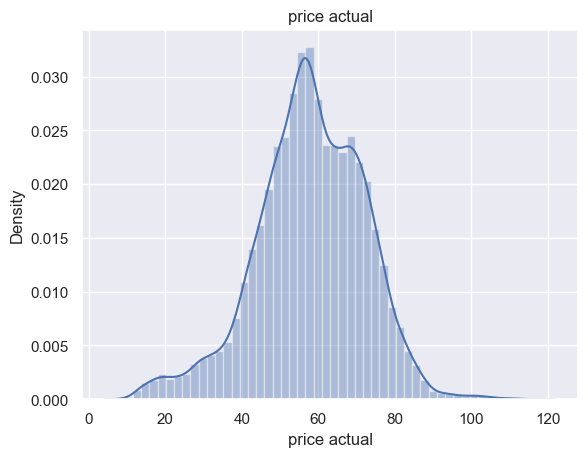

In [48]:
sns.distplot(df_energy["price actual"])
plt.title("price actual")

the actual energy price roughly follows a normal distribution

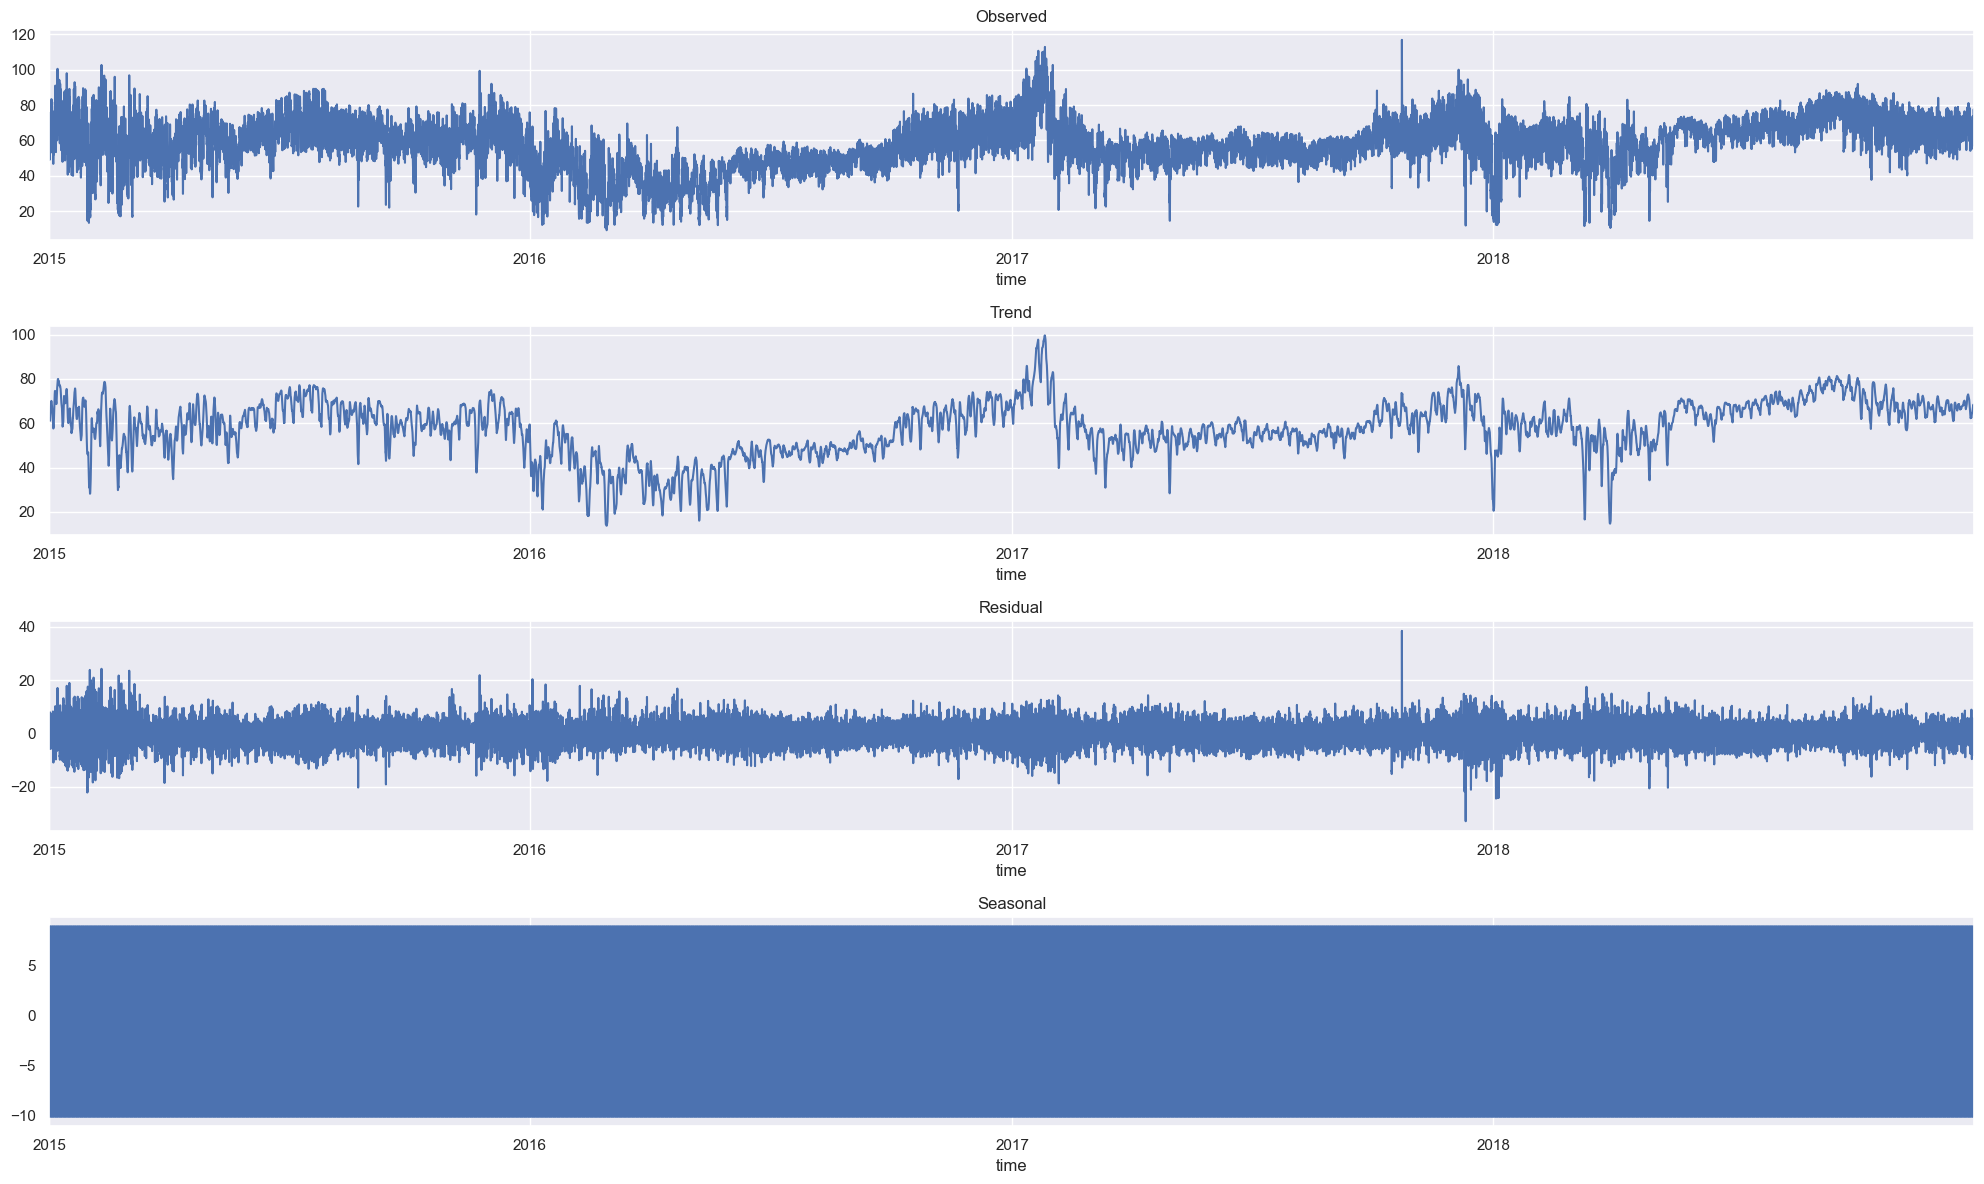

In [49]:
# Decompose the electricity price time series

res = sm.tsa.seasonal_decompose(df_energy['price actual'], model='additive')

fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(20, 12))
res.observed.plot(ax=ax1, title='Observed')
res.trend.plot(ax=ax2, title='Trend')
res.resid.plot(ax=ax3, title='Residual')
res.seasonal.plot(ax=ax4, title='Seasonal')
plt.tight_layout()
plt.show()

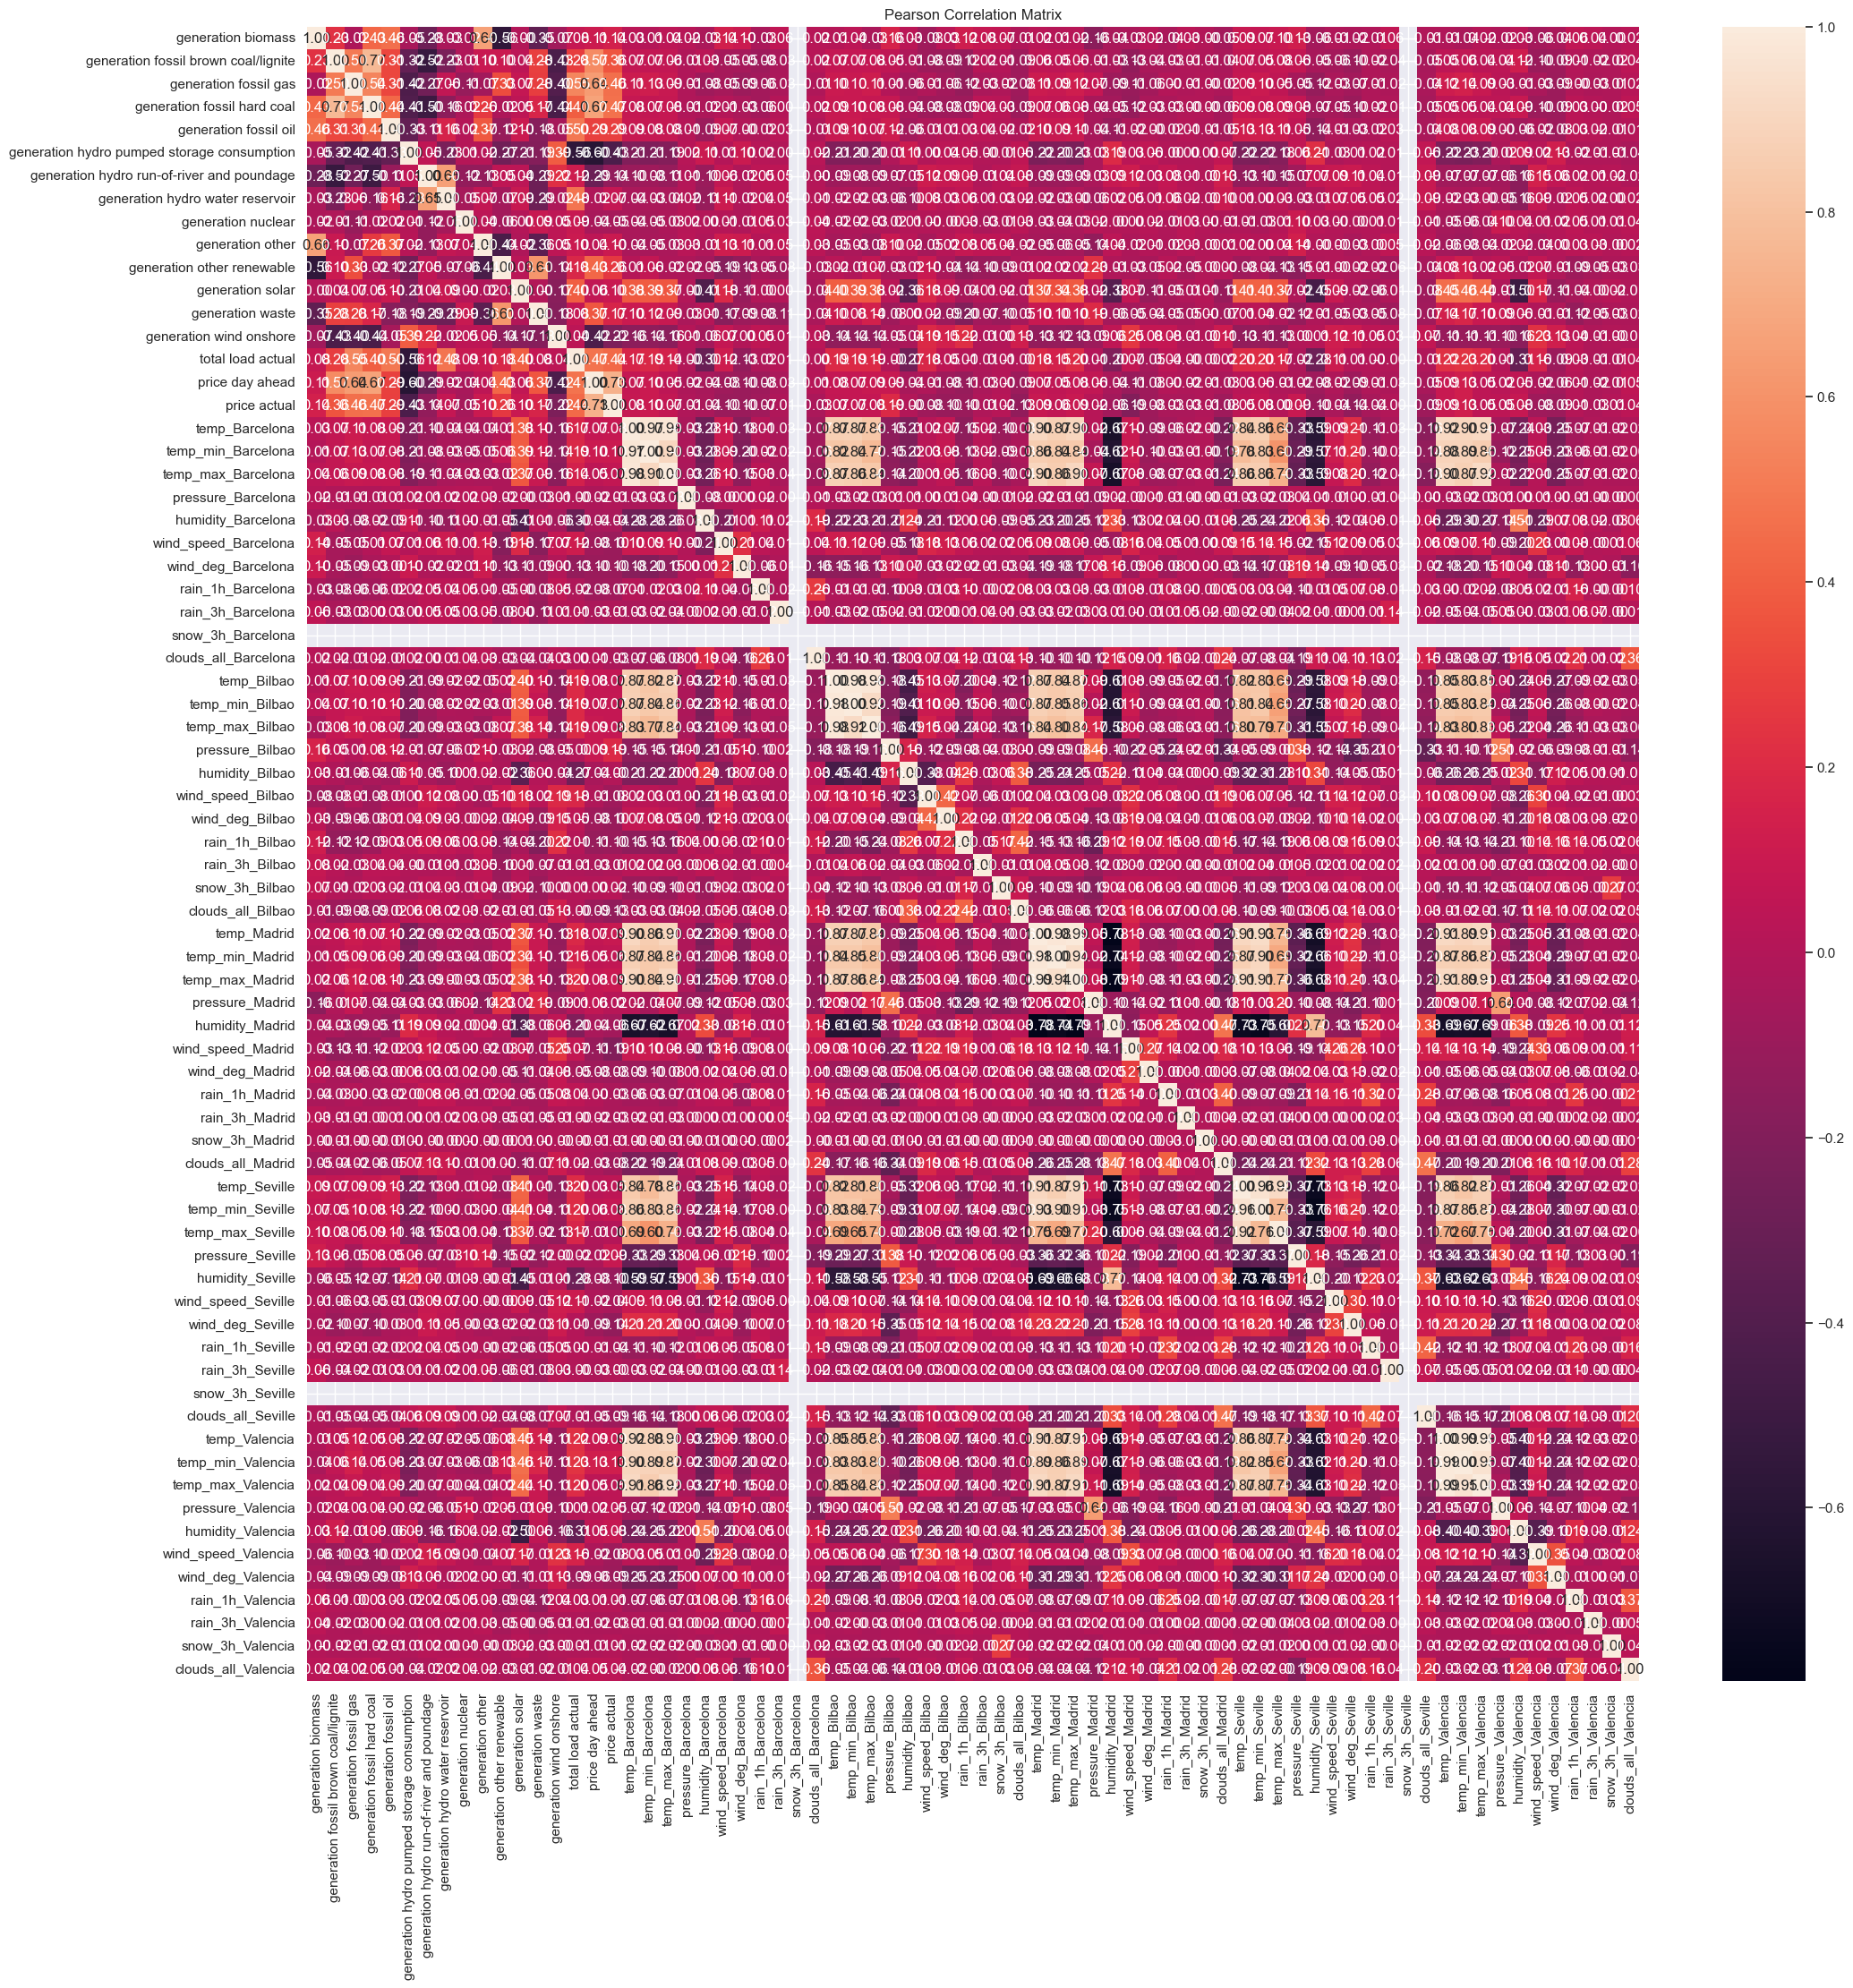

In [50]:
# Plot Pearson correlation matrix

correlations = df_final.corr(method='pearson')
fig = plt.figure(figsize=(24, 24))
sns.heatmap(correlations, annot=True, fmt='.2f')
plt.title('Pearson Correlation Matrix')
plt.show()

In [51]:
highly_correlated = abs(correlations[correlations > 0.5])
print(highly_correlated[highly_correlated < 1.0].stack().to_string())

generation biomass                          generation other                              0.658408
generation fossil brown coal/lignite        generation fossil hard coal                   0.768831
                                            price day ahead                               0.568159
generation fossil gas                       generation fossil hard coal                   0.541684
                                            total load actual                             0.548986
                                            price day ahead                               0.640907
generation fossil hard coal                 generation fossil brown coal/lignite          0.768831
                                            generation fossil gas                         0.541684
                                            price day ahead                               0.671786
generation hydro run-of-river and poundage  generation hydro water reservoir              0.652724
generation

# Feature Engineering

In [52]:
# Generate 'hour', 'weekday' and 'month' features

for i in range(len(df_final)):
    position = df_final.index[i]
    hour = position.hour
    weekday = position.weekday()
    month = position.month
    df_final.loc[position, 'hour'] = hour
    df_final.loc[position, 'weekday'] = weekday
    df_final.loc[position, 'month'] = month

In [53]:
# Generate 'business hour' feature

for i in range(len(df_final)):
    position = df_final.index[i]
    hour = position.hour
    if ((hour > 8 and hour < 15) or (hour > 16 and hour < 22)):
        df_final.loc[position, 'business hour'] = 2
    elif (hour >= 15 and hour <= 16):
        df_final.loc[position, 'business hour'] = 1
    else:
        df_final.loc[position, 'business hour'] = 0

In [54]:
# Generate 'weekend' feature

for i in range(len(df_final)):
    position = df_final.index[i]
    weekday = position.weekday()
    if (weekday == 6):
        df_final.loc[position, 'weekday'] = 2   #Sunday
    elif (weekday == 5):
        df_final.loc[position, 'weekday'] = 1   #Saturday
    else:
        df_final.loc[position, 'weekday'] = 0   #weekday

In [55]:
# To reduce dimensionality, the data will be substracted (temp_min and temp_max)
# Generate 'temp_range' for each city

cities = ['Barcelona', 'Bilbao', 'Madrid', 'Seville', 'Valencia']

for i in range(len(df_final)):
    position = df_final.index[i]
    for city in cities:
        temp_max = df_final.loc[position, 'temp_max_{}'.format(city)]
        temp_min = df_final.loc[position, 'temp_min_{}'.format(city)]
        df_final.loc[position, 'temp_range_{}'.format(city)] = abs(temp_max - temp_min)

In [56]:
# Calculate the weight of every city

total_population = 6155116 + 5179243 + 1645342 + 1305342 + 987000

weight_Madrid = 6155116 / total_population
weight_Barcelona = 5179243 / total_population
weight_Valencia = 1645342 / total_population
weight_Seville = 1305342 / total_population
weight_Bilbao = 987000 / total_population

In [57]:
cities_weights = {'Madrid': weight_Madrid, 
                  'Barcelona': weight_Barcelona,
                  'Valencia': weight_Valencia,
                  'Seville': weight_Seville,
                  'Bilbao': weight_Bilbao}

In [58]:
# coal-based power generations will be merged into generation coal all due to high correlation
df_final['generation coal all'] = df_final['generation fossil hard coal'] + df_final['generation fossil brown coal/lignite']

## Feature Selection

In [59]:
def multivariate_data(dataset, target, start_index, end_index, history_size,
                      target_size, step, single_step=False):
    data = []
    labels = []

    start_index = start_index + history_size
    if end_index is None:
        end_index = len(dataset) - target_size
        
    for i in range(start_index, end_index):
        indices = range(i-history_size, i, step)
        data.append(dataset[indices])
        
        if single_step:
            labels.append(target[i + target_size])
        else:
            labels.append(target[i : i + target_size])

    return np.array(data), np.array(labels)

In [60]:
train_end_idx = 27048
cv_end_idx = 31056
test_end_idx = 35064

In [60]:
len(df_final)

35064

In [64]:
train_df = int(len(df_final) * 0.70)
val_df = int(len(df_final) * 0.20)
test_df = int(len(df_final) * 0.10)

print('Train size:', train_df)
print('Validation size:', val_df)
print('Test size:', test_df)


Train size: 24544
Validation size: 7012
Test size: 3506


In [61]:
X = df_final[df_final.columns.drop('price actual')].values
y = df_final['price actual'].values

y = y.reshape(-1, 1)

In [62]:
scaler_X = MinMaxScaler(feature_range=(0, 1))
scaler_y = MinMaxScaler(feature_range=(0, 1))

In [64]:
scaler_X.fit(X[:train_end_idx])
scaler_y.fit(y[:train_end_idx])

MinMaxScaler()

In [65]:
X_norm = scaler_X.transform(X)
y_norm = scaler_y.transform(y)

In [66]:
pca = PCA()
X_pca = pca.fit(X_norm[:train_end_idx])

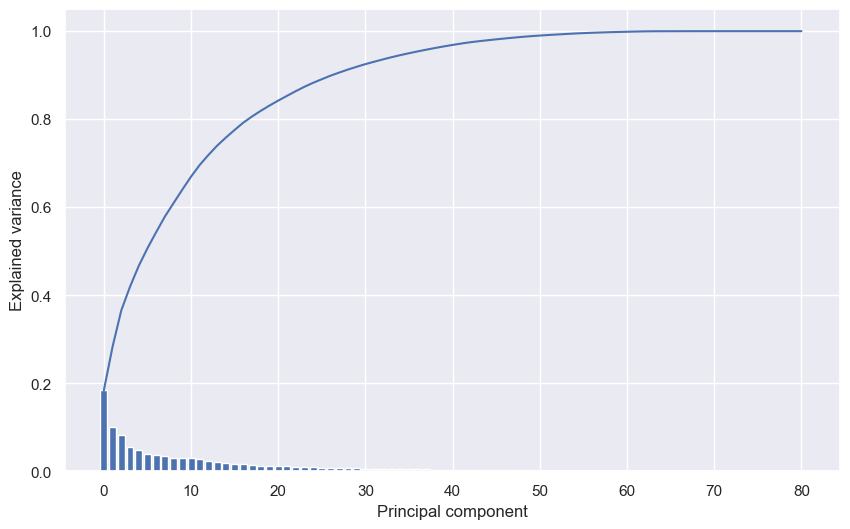

In [67]:
num_components = len(pca.explained_variance_ratio_)
plt.figure(figsize=(10, 6))
plt.bar(np.arange(num_components), pca.explained_variance_ratio_)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Principal component')
plt.ylabel('Explained variance')
plt.show()

In [69]:
pca = PCA(n_components=0.80)
pca.fit(X_norm[:train_end_idx])
X_pca = pca.transform(X_norm)

X_pca.shape

(35064, 18)

In [70]:
dataset_norm = np.concatenate((X_pca, y_norm), axis=1)

past_history = 24
future_target = 0

In [71]:
X_train, y_train = multivariate_data(dataset_norm, dataset_norm[:, -1],
                                     0, train_end_idx, past_history, 
                                     future_target, step=1, single_step=True)

In [72]:
X_val, y_val = multivariate_data(dataset_norm, dataset_norm[:, -1],
                                 train_end_idx, cv_end_idx, past_history, 
                                 future_target, step=1, single_step=True)

In [73]:
X_test, y_test = multivariate_data(dataset_norm, dataset_norm[:, -1],
                                   cv_end_idx, test_end_idx, past_history, 
                                   future_target, step=1, single_step=True)

In [74]:
train = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train = train.cache().shuffle(1000).batch(32).prefetch(1)

validation = tf.data.Dataset.from_tensor_slices((X_val, y_val))
validation = validation.batch(32).prefetch(1)

In [75]:
# Define some common parameters

input_shape = X_train.shape[-2:]
loss = tf.keras.losses.MeanSquaredError()
metric = [tf.keras.metrics.RootMeanSquaredError()]
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
              lambda epoch: 1e-4 * 10**(epoch / 10))
early_stopping = tf.keras.callbacks.EarlyStopping()

In [78]:
y_test.shape

(3984,)

In [79]:
y_test

array([0.55807886, 0.53981446, 0.51739467, ..., 0.62785079, 0.58523386,
       0.58513722])

In [76]:
y_test = y_test.reshape(-1, 1)
y_test_inv = scaler_y.inverse_transform(y_test)

## Electricity Price Forecasting

In [77]:
def plot_model_rmse_and_loss(history):
    
    # Evaluate train and validation accuracies and losses
    
    train_rmse = history.history['root_mean_squared_error']
    val_rmse = history.history['val_root_mean_squared_error']
    
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    # Visualize epochs vs. train and validation accuracies and losses
    
    plt.figure(figsize=(20, 10))
    plt.subplot(1, 2, 1)
    plt.plot(train_rmse, label='Training RMSE')
    plt.plot(val_rmse, label='Validation RMSE')
    plt.legend()
    plt.title('Epochs vs. Training and Validation RMSE')
    
    plt.subplot(1, 2, 2)
    plt.plot(train_loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.legend()
    plt.title('Epochs vs. Training and Validation Loss')
    
    plt.show()

In [78]:
from scikeras.wrappers import KerasRegressor
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam

In [84]:
tf.keras.backend.clear_session()

model = tf.keras.models.Sequential([
    LSTM(256, input_shape=input_shape, 
         return_sequences=True),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.1),
    Dense(1)
])

model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
                   'model.h5', monitor=('val_loss'), save_best_only=True)
optimizer = tf.keras.optimizers.Adam(lr=6e-3, amsgrad=True)

model.compile(loss=loss, optimizer=optimizer, metrics=metric)


In [85]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 24, 256)           282624    
                                                                 
 flatten (Flatten)           (None, 6144)              0         
                                                                 
 dense (Dense)               (None, 128)               786560    
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 1069313 (4.08 MB)
Trainable params: 1069313 (4.08 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [86]:
history = model.fit(train, epochs=100,
                                validation_data=validation,
                                callbacks=[early_stopping, 
                                           model_checkpoint])

Epoch 1/100


845/845 [==============================] - 38s 43ms/step - loss: 0.0101 - root_mean_squared_error: 0.0949 - val_loss: 0.0041 - val_root_mean_squared_error: 0.0644
Epoch 2/100
845/845 [==============================] - 35s 41ms/step - loss: 0.0030 - root_mean_squared_error: 0.0552 - val_loss: 0.0029 - val_root_mean_squared_error: 0.0540
Epoch 3/100
845/845 [==============================] - 36s 43ms/step - loss: 0.0023 - root_mean_squared_error: 0.0481 - val_loss: 0.0025 - val_root_mean_squared_error: 0.0499
Epoch 4/100
845/845 [==============================] - 36s 42ms/step - loss: 0.0019 - root_mean_squared_error: 0.0440 - val_loss: 0.0022 - val_root_mean_squared_error: 0.0470
Epoch 5/100
845/845 [==============================] - 36s 43ms/step - loss: 0.0017 - root_mean_squared_error: 0.0412 - val_loss: 0.0022 - val_root_mean_squared_error: 0.0466
Epoch 6/100
845/845 [==============================] - 36s 42ms/step - loss: 0.0015 - root_mean_squared_error: 0.0386 - val_loss: 0.0016 

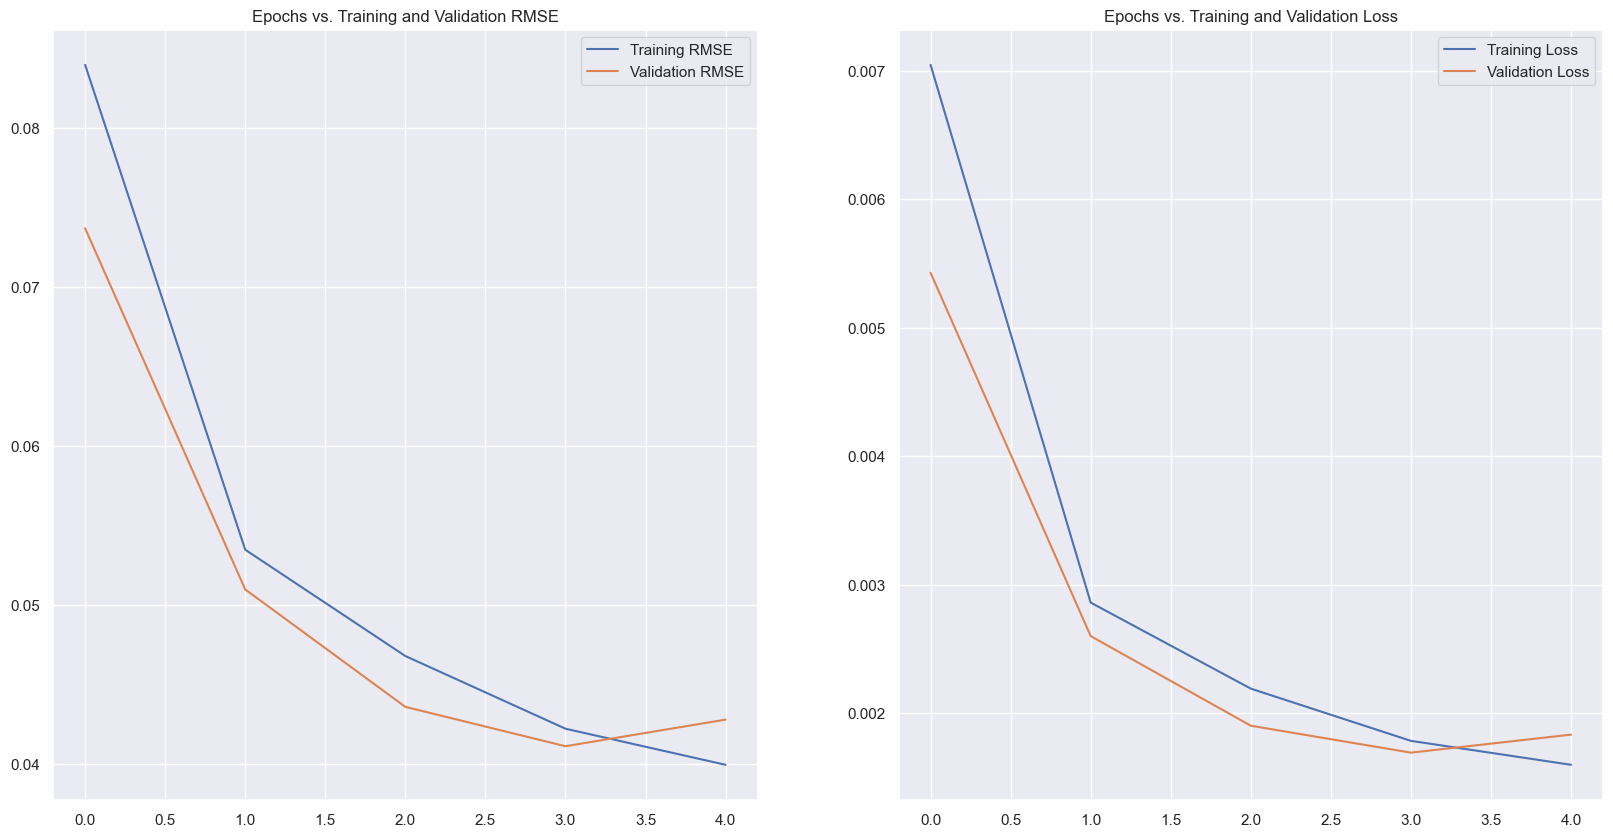

In [82]:
plot_model_rmse_and_loss(history)

In [87]:
model = tf.keras.models.load_model('model.h5')

forecast = model.predict(X_test)
lstm_forecast = scaler_y.inverse_transform(forecast)

rmse_lstm = sqrt(mean_squared_error(y_test_inv,
                                    lstm_forecast))
print('RMSE of hour-ahead electricity price LSTM forecast: {}'
      .format(round(rmse_lstm, 3)))

125/125 [==============================] - 2s 15ms/step
RMSE of hour-ahead electricity price LSTM forecast: 3.608


In [88]:
y_test

array([[0.53735926],
       [0.51977296],
       [0.49818554],
       ...,
       [0.6045408 ],
       [0.56350609],
       [0.56341305]])

In [89]:
forecast

array([[0.4967009 ],
       [0.47485417],
       [0.472321  ],
       ...,
       [0.6442667 ],
       [0.59753835],
       [0.5720836 ]], dtype=float32)

In [90]:
y_test_inv

array([[67.08],
       [65.19],
       [62.87],
       ...,
       [74.3 ],
       [69.89],
       [69.88]])

In [91]:
lstm_forecast

array([[62.710445],
       [60.36258 ],
       [60.090336],
       ...,
       [78.56934 ],
       [73.54745 ],
       [70.81183 ]], dtype=float32)

In [92]:
y_test_inv = y_test_inv.ravel()

In [93]:
columns = pd.DataFrame(data={
    'Price actual':y_test_inv,
    'Price prediction':[x[0] for x in lstm_forecast]
})

columns

Price actual  Price prediction
0            67.08         62.710445
1            65.19         60.362579
2            62.87         60.090336
3            63.02         58.725002
4            64.50         59.192051
...            ...               ...
3979         77.02         85.510971
3980         76.16         83.652931
3981         74.30         78.569344
3982         69.89         73.547447
3983         69.88         70.811829

[3984 rows x 2 columns]

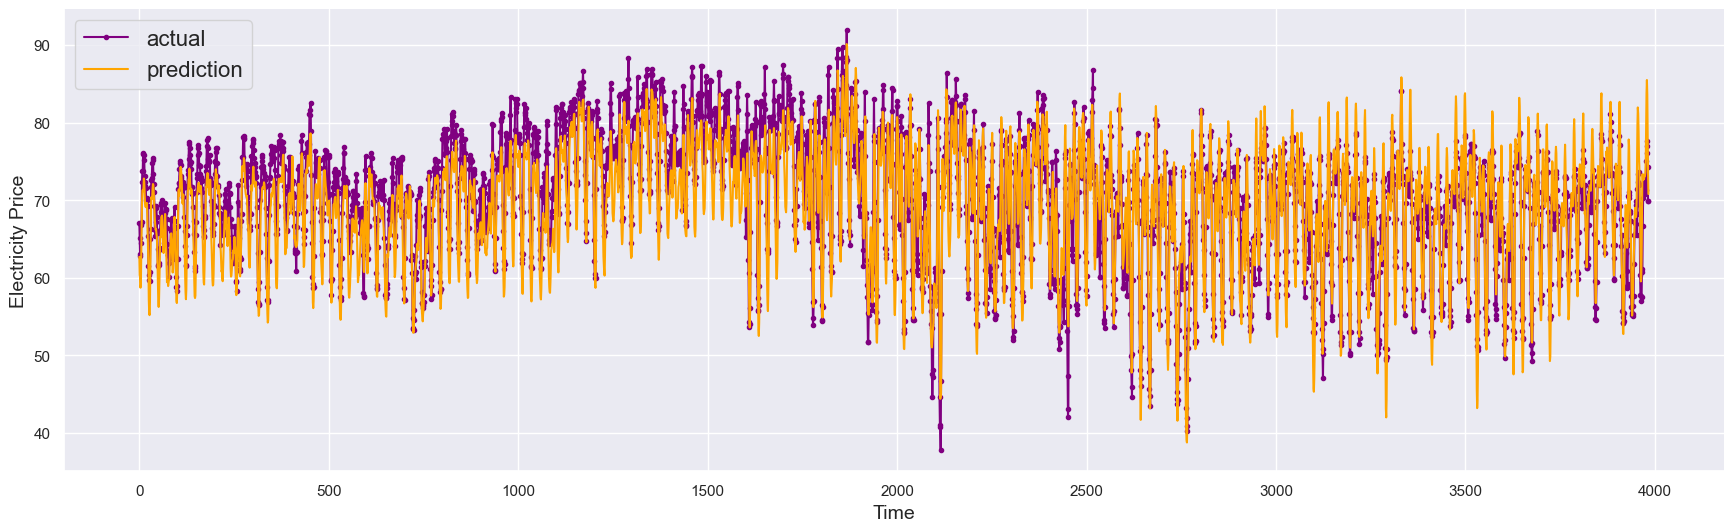

In [94]:
aa=[x for x in range(3984)]
# Creating a figure object with desired figure size
plt.figure(figsize=(20,6))

# Plotting the actual values in blue with a dot marker
plt.plot(aa, y_test_inv, marker='.', label="actual", color='purple')

# Plotting the predicted values in green with a solid line
plt.plot(aa, lstm_forecast, '-', label="prediction", color='orange')

# Removing the top spines
sns.despine(top=True)

# Adjusting the subplot location
plt.subplots_adjust(left=0.07)

# Labeling the y-axis
plt.ylabel('Electricity Price', size=14)

# Labeling the x-axis
plt.xlabel('Time', size=14)

# Adding a legend with font size of 15
plt.legend(fontsize=16)

# Display the plot
plt.show()

In [95]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

test_rmse = np.sqrt(mean_squared_error(y_test, forecast))

print('Test RMSE:', test_rmse)

Test RMSE: 0.033575320711210846


In [96]:
import pickle

with open('model_electricity.pkl', 'wb') as file:
    pickle.dump(model, file)

INFO:tensorflow:Assets written to: C:\Users\Oka\AppData\Local\Temp\tmpbyzxkcnj\assets


INFO:tensorflow:Assets written to: C:\Users\Oka\AppData\Local\Temp\tmpbyzxkcnj\assets


In [97]:
import joblib

filename = 'model_electr_price.sav'
joblib.dump(model, filename)

INFO:tensorflow:Assets written to: C:\Users\Oka\AppData\Local\Temp\tmpt6t6mjy9\assets


INFO:tensorflow:Assets written to: C:\Users\Oka\AppData\Local\Temp\tmpt6t6mjy9\assets


['model_electr_price.sav']

In [98]:
with open('model_electricity_price.sav', 'wb') as file:
    pickle.dump(model, file)

INFO:tensorflow:Assets written to: C:\Users\Oka\AppData\Local\Temp\tmp_c1fi2vq\assets


INFO:tensorflow:Assets written to: C:\Users\Oka\AppData\Local\Temp\tmp_c1fi2vq\assets


# Hyperparameter Tuning

In [99]:
from sklearn.model_selection import GridSearchCV
from scikeras.wrappers import KerasRegressor

In [100]:
def create_tuning_model():
    model = tf.keras.models.Sequential([LSTM(128, input_shape=input_shape, return_sequences=True),
                                        Flatten(), 
                                        Dense(100, activation='relu'), 
                                        Dropout(0.1),
                                        Dense(1)])

    model_checkpoint = tf.keras.callbacks.ModelCheckpoint('multivariate_lstm.h5', monitor=('val_loss'), save_best_only=True)
    optimizer = tf.keras.optimizers.Adam(lr=6e-3, amsgrad=True)

    model.compile(loss=loss, optimizer=optimizer, metrics=metric)

    return model

In [101]:
# Create estimator from Keras model using KerasRegressor
lstm_regressor = KerasRegressor(build_fn=create_tuning_model, verbose=0)

# define the grid search parameters

param_grid={'epochs':[10, 20, 30],
            'optimizer': ['SGD', 'RMSprop', 'Adam']}

# Inisialisasi GridSearchCV
grid_search = GridSearchCV(estimator=lstm_regressor, param_grid=param_grid, cv=3, n_jobs=-1)

# Melakukan pencarian parameter terbaik
grid_result = grid_search.fit(X_train, y_train)

# Menampilkan hasil terbaik
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

Best: 0.925516 using {'epochs': 30, 'optimizer': 'SGD'}


In [102]:
# Create the model again using the best params
best_epochs = grid_result.best_params_['epochs']
best_optimizer = grid_result.best_params_['optimizer']
model_param= create_tuning_model()

# Compile the model with the best optimizer
model_param.compile(loss=loss, optimizer=best_optimizer, metrics=metric)

# Fit the model on the training data
history_param = model_param.fit(train, epochs=best_epochs,
                                validation_data=validation,
                                callbacks=[early_stopping, 
                                           model_checkpoint])

# Evaluate the model
loss, accuracy = model_param.evaluate(X_test, y_test)
print(f"Test Loss: {loss}, Test Accuracy: {accuracy}")


Epoch 1/30
845/845 [==============================] - 12s 12ms/step - loss: 0.0099 - root_mean_squared_error: 0.0721 - val_loss: 0.0064 - val_root_mean_squared_error: 0.0802
Epoch 2/30
845/845 [==============================] - 10s 11ms/step - loss: 0.0051 - root_mean_squared_error: 0.0711 - val_loss: 0.0053 - val_root_mean_squared_error: 0.0731
Epoch 3/30
845/845 [==============================] - 10s 12ms/step - loss: 0.0043 - root_mean_squared_error: 0.0656 - val_loss: 0.0048 - val_root_mean_squared_error: 0.0689
Epoch 4/30
845/845 [==============================] - 11s 13ms/step - loss: 0.0039 - root_mean_squared_error: 0.0622 - val_loss: 0.0045 - val_root_mean_squared_error: 0.0674
Epoch 5/30
845/845 [==============================] - 11s 13ms/step - loss: 0.0035 - root_mean_squared_error: 0.0592 - val_loss: 0.0042 - val_root_mean_squared_error: 0.0648
Epoch 6/30
845/845 [==============================] - 11s 13ms/step - loss: 0.0033 - root_mean_squared_error: 0.0573 - val_loss: 0

In [103]:
model = tf.keras.models.load_model('multivariate_lstm.h5')

forecast_tuning = model.predict(X_test)
lstm_forecast_tuning = scaler_y.inverse_transform(forecast_tuning)

rmse_lstm_tuning = sqrt(mean_squared_error(y_test_inv,
                                    lstm_forecast_tuning))
print('RMSE of hour-ahead electricity price LSTM forecast tuning: {}'
      .format(round(rmse_lstm_tuning, 3)))

125/125 [==============================] - 1s 6ms/step
RMSE of hour-ahead electricity price LSTM forecast tuning: 3.289


In [104]:
columns_tuning = pd.DataFrame(data={
    'Price actual':y_test_inv,
    'Price prediction':[x[0] for x in lstm_forecast_tuning]
})

columns_tuning

Price actual  Price prediction
0            67.08         61.073158
1            65.19         59.122452
2            62.87         59.550419
3            63.02         59.793022
4            64.50         60.504704
...            ...               ...
3979         77.02         80.947464
3980         76.16         80.374641
3981         74.30         76.729744
3982         69.89         72.664024
3983         69.88         68.688820

[3984 rows x 2 columns]

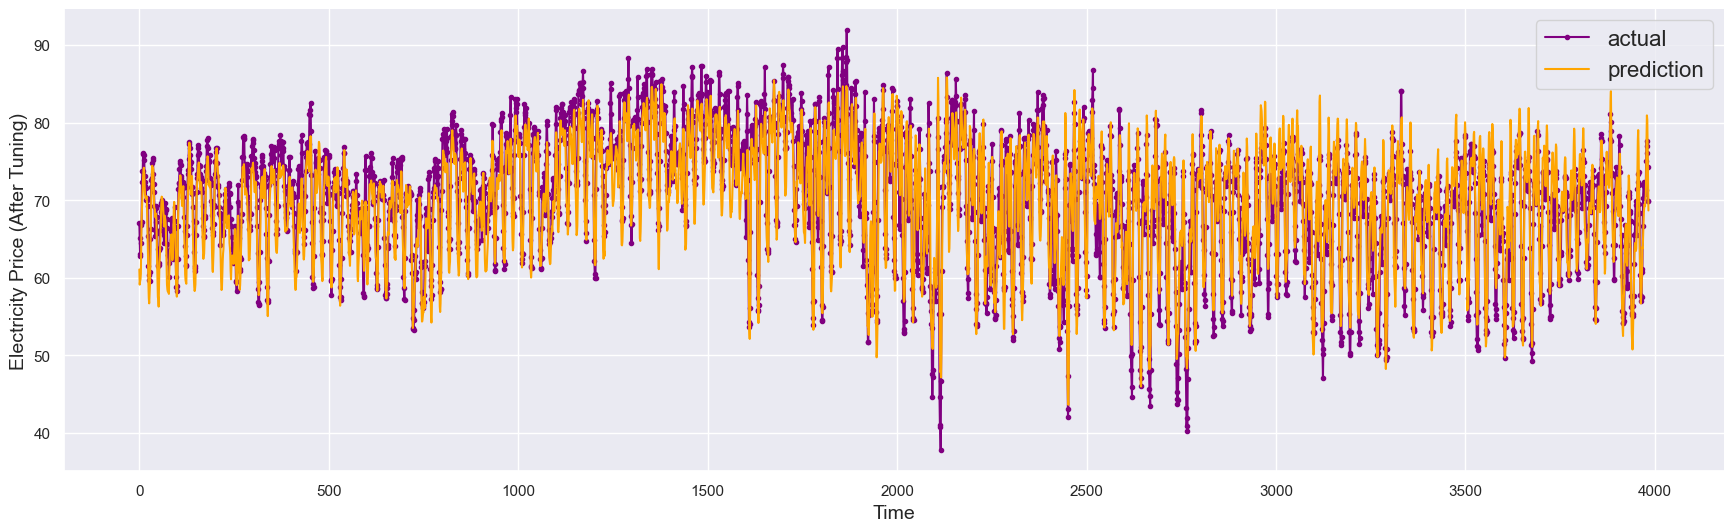

In [105]:
aa=[x for x in range(3984)]
# Creating a figure object with desired figure size
plt.figure(figsize=(20,6))

# Plotting the actual values in blue with a dot marker
plt.plot(aa, y_test_inv, marker='.', label="actual", color='purple')

# Plotting the predicted values in green with a solid line
plt.plot(aa, lstm_forecast_tuning, '-', label="prediction", color='orange')

# Removing the top spines
sns.despine(top=True)

# Adjusting the subplot location
plt.subplots_adjust(left=0.07)

# Labeling the y-axis
plt.ylabel('Electricity Price (After Tuning)', size=14)

# Labeling the x-axis
plt.xlabel('Time', size=14)

# Adding a legend with font size of 15
plt.legend(fontsize=16)

# Display the plot
plt.show()

In [106]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

test_rmse_tuning = np.sqrt(mean_squared_error(y_test, forecast_tuning))

print('Test RMSE:', test_rmse_tuning)

Test RMSE: 0.030602207561435047


In [107]:
import pickle

with open('model_electricity_tuning.sav', 'wb') as file:
    pickle.dump(model, file)

INFO:tensorflow:Assets written to: C:\Users\Oka\AppData\Local\Temp\tmphdwk48v4\assets


INFO:tensorflow:Assets written to: C:\Users\Oka\AppData\Local\Temp\tmphdwk48v4\assets


According to the hyperparameter tuning process, the result show that there is slight differences between after and before tuning. 